In [1]:
#importing library files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

In [10]:
quantity = pd.read_excel(r"C:\Users\jagad\OneDrive\Desktop\infosys project\ProductA.xlsx")
impression = pd.read_excel(r"C:\Users\jagad\OneDrive\Desktop\infosys project\ProductA_fb_impressions (1).xlsx")
clicks = pd.read_excel(r"C:\Users\jagad\OneDrive\Desktop\infosys project\ProductA_google_clicks.xlsx")


In [12]:
merged = pd.read_excel(r"C:\Users\jagad\OneDrive\Desktop\infosys project\ProductA_google_clicks.xlsx").merge(pd.read_excel(r"C:\Users\jagad\OneDrive\Desktop\infosys project\ProductA_fb_impressions (1).xlsx"),on="Day Index").merge(pd.read_excel(r"C:\Users\jagad\OneDrive\Desktop\infosys project\ProductA.xlsx"),on="Day Index")

In [13]:
merged.head()

,Day Index,Clicks,Impressions,Quantity
0,2021-12-01,445,620,14
1,2021-12-02,433,890,10
2,2021-12-03,424,851,13
3,2021-12-04,427,881,22
4,2021-12-05,451,678,33


In [14]:
merged.tail()

,Day Index,Clicks,Impressions,Quantity
207,2022-06-26,114,1218,13
208,2022-06-27,106,1311,16
209,2022-06-28,109,885,13
210,2022-06-29,60,1000,16
211,2022-06-30,65,875,8


In [15]:
merged.shape

(212, 4)

In [16]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Clicks       212 non-null    int64         
 2   Impressions  212 non-null    int64         
 3   Quantity     212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [17]:
merged.describe()

,Day Index,Clicks,Impressions,Quantity
count,212,212.00000,212.000000,212.000000
mean,2022-03-16 12:00:00,358.20283,1531.702830,17.542453
min,2021-12-01 00:00:00,60.00000,620.000000,5.000000
25%,2022-01-22 18:00:00,154.00000,1209.750000,13.750000
50%,2022-03-16 12:00:00,402.50000,1460.000000,17.000000
75%,2022-05-08 06:00:00,492.75000,1862.000000,21.000000
max,2022-06-30 00:00:00,726.00000,2707.000000,38.000000
std,NaN,164.52160,440.660783,5.790423


In [18]:
merged.isnull().sum()

Day Index      0
Clicks         0
Impressions    0
Quantity       0
dtype: int64

<Axes: >

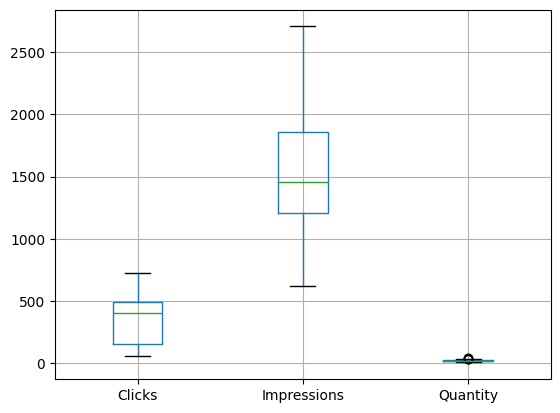

In [19]:

merged.boxplot()

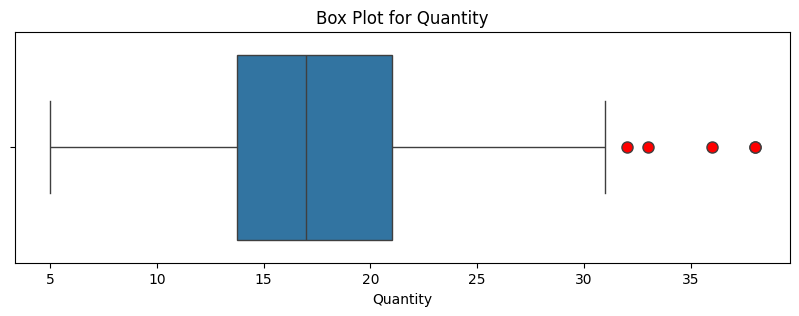

In [20]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Quantity'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Quantity")
plt.title("Box Plot for Quantity")
plt.show()

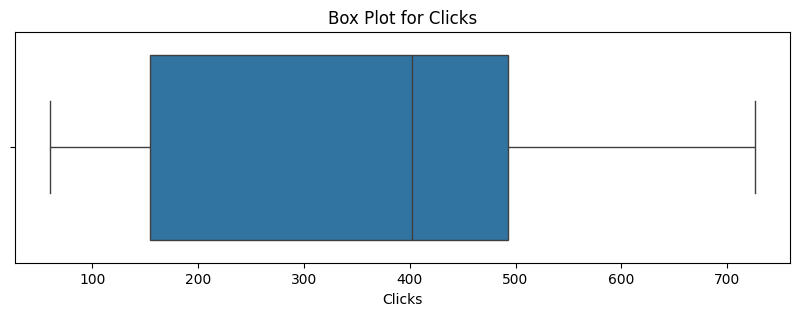

In [21]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Clicks'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Clicks")
plt.title("Box Plot for Clicks")
plt.show()

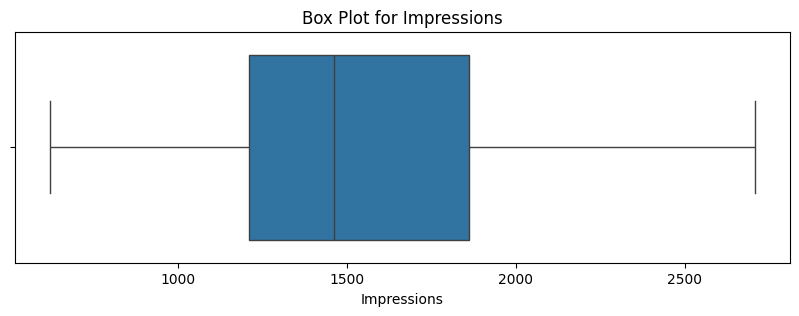

In [22]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Impressions'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Impressions")
plt.title("Box Plot for Impressions")
plt.show()

In [23]:
def outlier_finding(merged):
    q1 , q3 = merged.quantile(0.25), merged.quantile(0.75)
    IQR = q3 - q1
    outliers = merged[(merged < (q1 - 1.5 *IQR))| (merged > (q3 + 1.5 * IQR))]
    return outliers
outlier_quantity = len(outlier_finding(merged['Quantity']))
outlier_clicks = len(outlier_finding(merged['Clicks']))
outlier_impressions = len(outlier_finding(merged['Impressions']))
#printing outliers
print("Outliers in Quantity:",outlier_quantity)
print("Outliers in Clicks:",outlier_clicks)
print("Outlier in Impressions:",outlier_impressions)

Outliers in Quantity: 5
Outliers in Clicks: 0
Outlier in Impressions: 0


In [24]:
print("Quantity: \n",outlier_finding(merged['Quantity']))

Quantity: 
 4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


In [25]:
percentile = merged["Quantity"].quantile(0.96)
print(percentile)

28.560000000000002


In [26]:
def outlier_percentile(series):
    q1, q3 = series.quantile([0.25,0.75])
    IQR = q3 - q1
    #calculating upper and lower bound
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR
    percentile_96 = series.quantile(0.96)
    return series.apply(lambda x: percentile_96 if(x < lower or x > upper)else x)

In [27]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

In [29]:
print("quantity:\t",len(outlier_finding(merged['imputed_quantity'])))

quantity:	 0


In [30]:
merged.head()

,Day Index,Clicks,Impressions,Quantity,imputed_quantity
0,2021-12-01,445,620,14,14.00
1,2021-12-02,433,890,10,10.00
2,2021-12-03,424,851,13,13.00
3,2021-12-04,427,881,22,22.00
4,2021-12-05,451,678,33,28.56


In [31]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

In [32]:
merged['log_quantity'] = np.log1p(merged['Quantity'])
merged['log_clicks'] = np.log1p(merged['Clicks'])
merged['log_impression'] = np.log1p(merged['Impressions'])

In [33]:
merged['log_quantity'] = np.log1p(merged['Quantity'])
merged['log_clicks'] = np.log1p(merged['Clicks'])
merged['log_impression'] = np.log1p(merged['Impressions'])

In [36]:
merged['ym'] = merged['Day Index'].dt.to_period('M')

In [37]:
merged['MonthName'] = merged['ym'].dt.strftime('%B')
month_order = ['December','January','February','March','April','May','June']
merged['MonthName'] = pd.Categorical(merged['MonthName'], categories = month_order, ordered = True)

In [38]:
merged['daysofweek'] = merged['Day Index'].dt.day_name()
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
merged['daysofweek'] = pd.Categorical(merged['daysofweek'], categories = order_week, ordered = True)

In [39]:
def weekOfMonth(date):
    first_day = date.replace(day=1)
    adjusted_dom = date.day + first_day.weekday()
    return int(np.ceil(adjusted_dom/7.0))

merged['weekOfMonth'] = merged['Day Index'].apply(weekOfMonth)

In [40]:
def dayToNumber(day):
    day_orders = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    return day_orders.get(day,0)

def monthToNumber(month):
    month_orders = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    return month_orders.get(month,0)

merged['daysOfWeekNum'] = merged['daysofweek'].apply(dayToNumber)
merged['MonthNum'] = merged['MonthName'].apply(monthToNumber)

In [41]:
def dayToNumber(day):
    day_orders = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    return day_orders.get(day,0)

def monthToNumber(month):
    month_orders = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    return month_orders.get(month,0)

merged['daysOfWeekNum'] = merged['daysofweek'].apply(dayToNumber)
merged['MonthNum'] = merged['MonthName'].apply(monthToNumber)

In [42]:
merged.loc[merged['daysofweek'] == 'Monday', 'Weekday_Monday'] = 1
merged.loc[merged['daysofweek'] == 'Tuesday', 'Weekday_Tuesday'] = 1
merged.loc[merged['daysofweek'] == 'Wednesday', 'Weekday_Wednesday'] = 1
merged.loc[merged['daysofweek'] == 'Thursday', 'Weekday_Thursday'] = 1
merged.loc[merged['daysofweek'] == 'Friday', 'Weekday_Friday'] = 1
merged.loc[merged['daysofweek'] == 'Saturday', 'Weekday_Saturday'] = 1
merged.loc[merged['daysofweek'] == 'Sunday', 'Weekday_Sunday'] = 1

merged.loc[merged['MonthName'] == 'January', 'Weekday_January'] = 1
merged.loc[merged['MonthName'] == 'February', 'Weekday_February'] = 1
merged.loc[merged['MonthName'] == 'March', 'Weekday_March'] = 1
merged.loc[merged['MonthName'] == 'April', 'Weekday_April'] = 1
merged.loc[merged['MonthName'] == 'May', 'Weekday_May'] = 1
merged.loc[merged['MonthName'] == 'June', 'Weekday_June'] = 1
merged.loc[merged['MonthName'] == 'July', 'Weekday_July'] = 1
merged.loc[merged['MonthName'] == 'August', 'Weekday_August'] = 1
merged.loc[merged['MonthName'] == 'September', 'Weekday_September'] = 1
merged.loc[merged['MonthName'] == 'October', 'Weekday_October'] = 1
merged.loc[merged['MonthName'] == 'November', 'Weekday_November'] = 1
merged.loc[merged['MonthName'] == 'December', 'Weekday_December'] = 1

In [43]:
weekday_columns = ['Weekday_Monday','Weekday_Tuesday','Weekday_Wednesday','Weekday_Thursday','Weekday_Friday','Weekday_Saturday','Weekday_Sunday']
month_columns = ['Weekday_January','Weekday_February','Weekday_March','Weekday_April','Weekday_May', 'Weekday_June', 'Weekday_July','Weekday_August','Weekday_September','Weekday_October','Weekday_November','Weekday_December']
#fill 0 for NAN
merged[weekday_columns] = merged[weekday_columns].fillna(0)
merged[month_columns] = merged[month_columns].fillna(0)

In [44]:
merged.columns

Index(['Day Index', 'Clicks', 'Impressions', 'Quantity', 'imputed_quantity',
       'log_quantity', 'log_clicks', 'log_impression', 'ym', 'MonthName',
       'daysofweek', 'weekOfMonth', 'daysOfWeekNum', 'MonthNum',
       'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_January', 'Weekday_February',
       'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',
       'Weekday_July', 'Weekday_August', 'Weekday_September',
       'Weekday_October', 'Weekday_November', 'Weekday_December'],
      dtype='object')

In [45]:
merged.head()

,Day Index,Clicks,Impressions,Quantity,imputed_quantity,log_quantity,log_clicks,log_impression,ym,MonthName,...,Weekday_March,Weekday_April,Weekday_May,Weekday_June,Weekday_July,Weekday_August,Weekday_September,Weekday_October,Weekday_November,Weekday_December
0,2021-12-01,445,620,14,14.00,2.708050,6.100319,6.431331,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2021-12-02,433,890,10,10.00,2.397895,6.073045,6.792344,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2021-12-03,424,851,13,13.00,2.639057,6.052089,6.747587,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2021-12-04,427,881,22,22.00,3.135494,6.059123,6.782192,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2021-12-05,451,678,33,28.56,3.526361,6.113682,6.520621,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


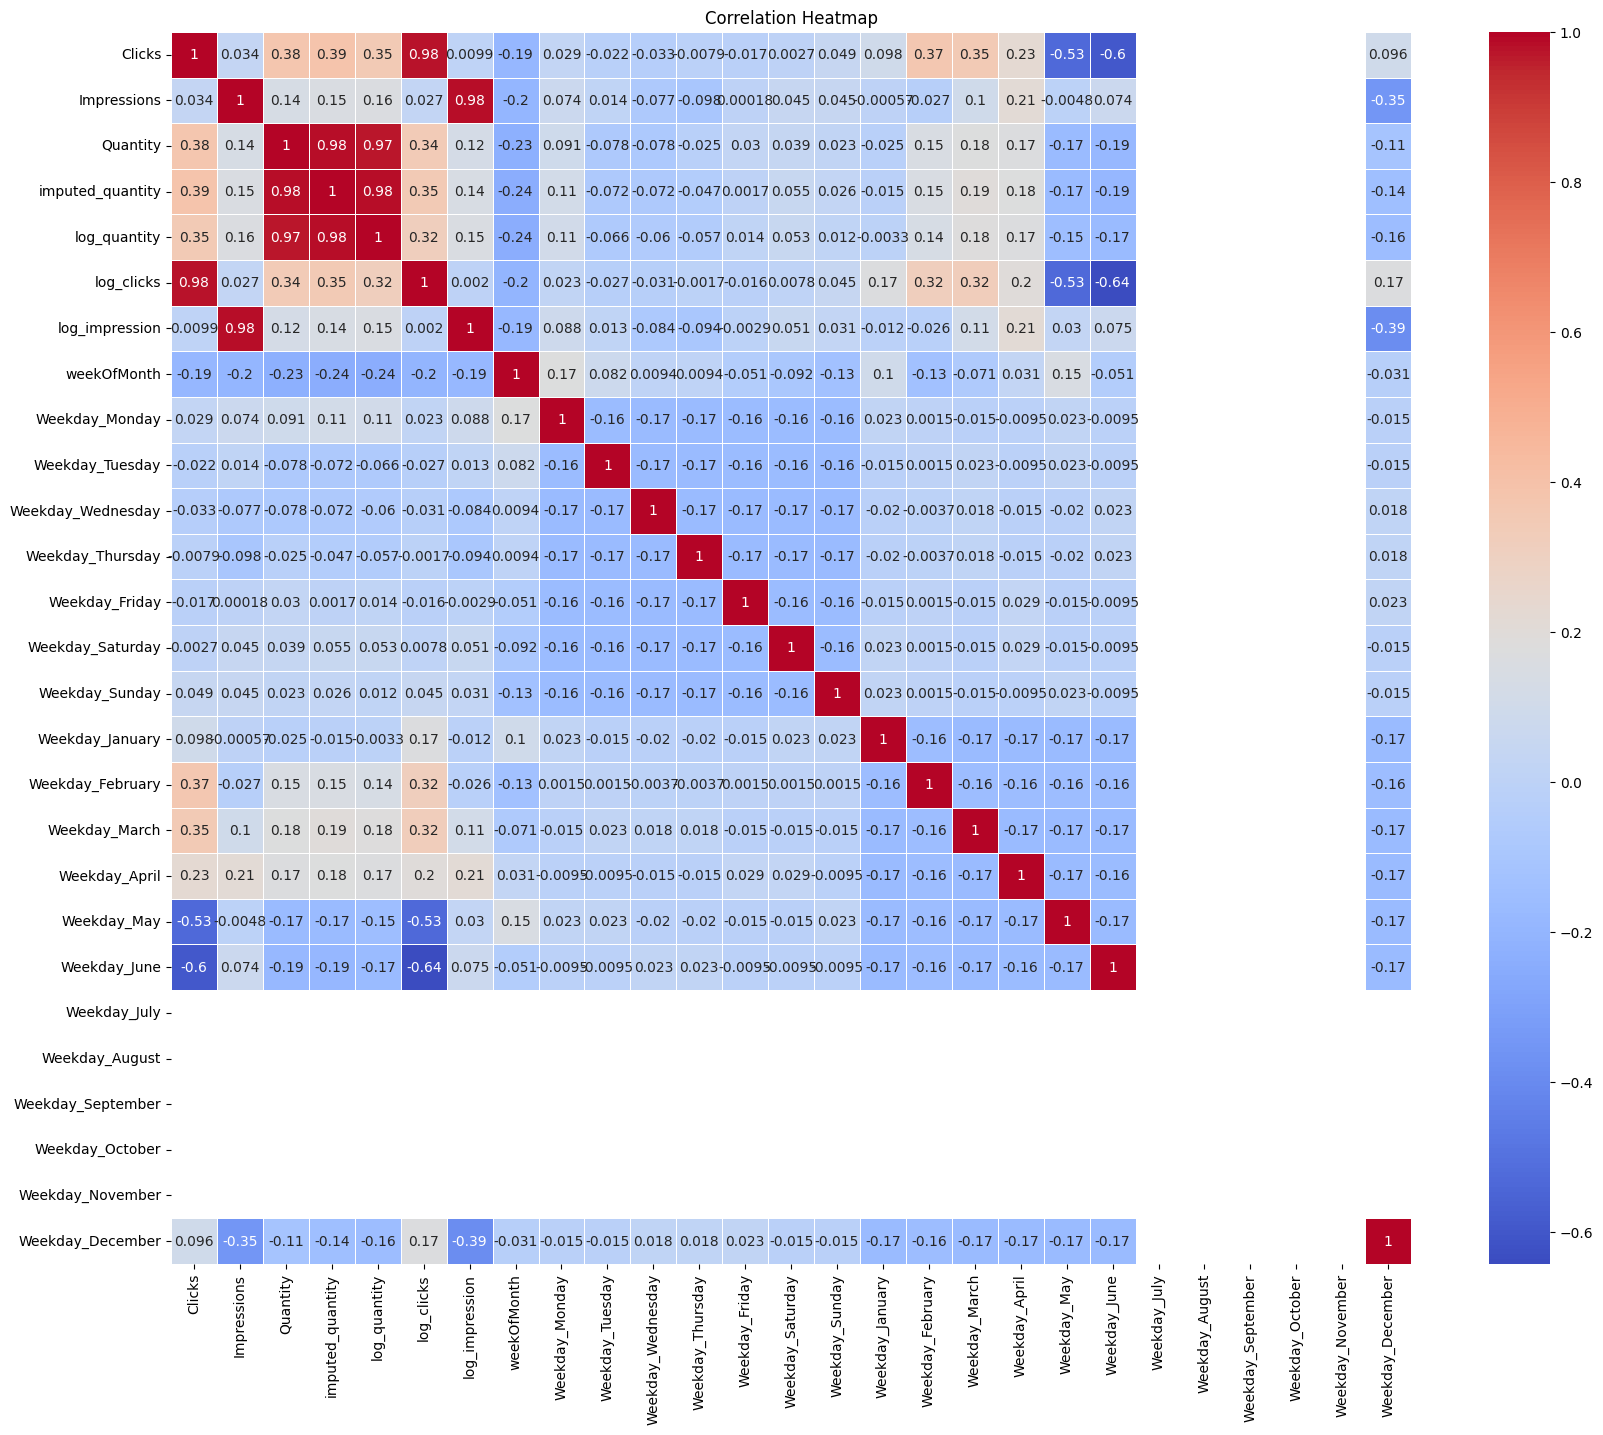

In [46]:
plt.figure(figsize=(20,16))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5).set_title("Correlation Heatmap")
plt.show()

In [47]:
def regression(merged, x_col, y_col, title, ax):
    x = merged[x_col].values.reshape(-1,1)
    y = merged[y_col].values
    model = LinearRegression()
    model.fit(x,y)
    y_pre = model.predict(x)
    #to get slope
    slope = model.coef_[0]
    ax.scatter(merged[x_col], merged[y_col], label='Actual')
    ax.plot(merged[x_col], y_pre,color='red',label='Regression')
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    return slope

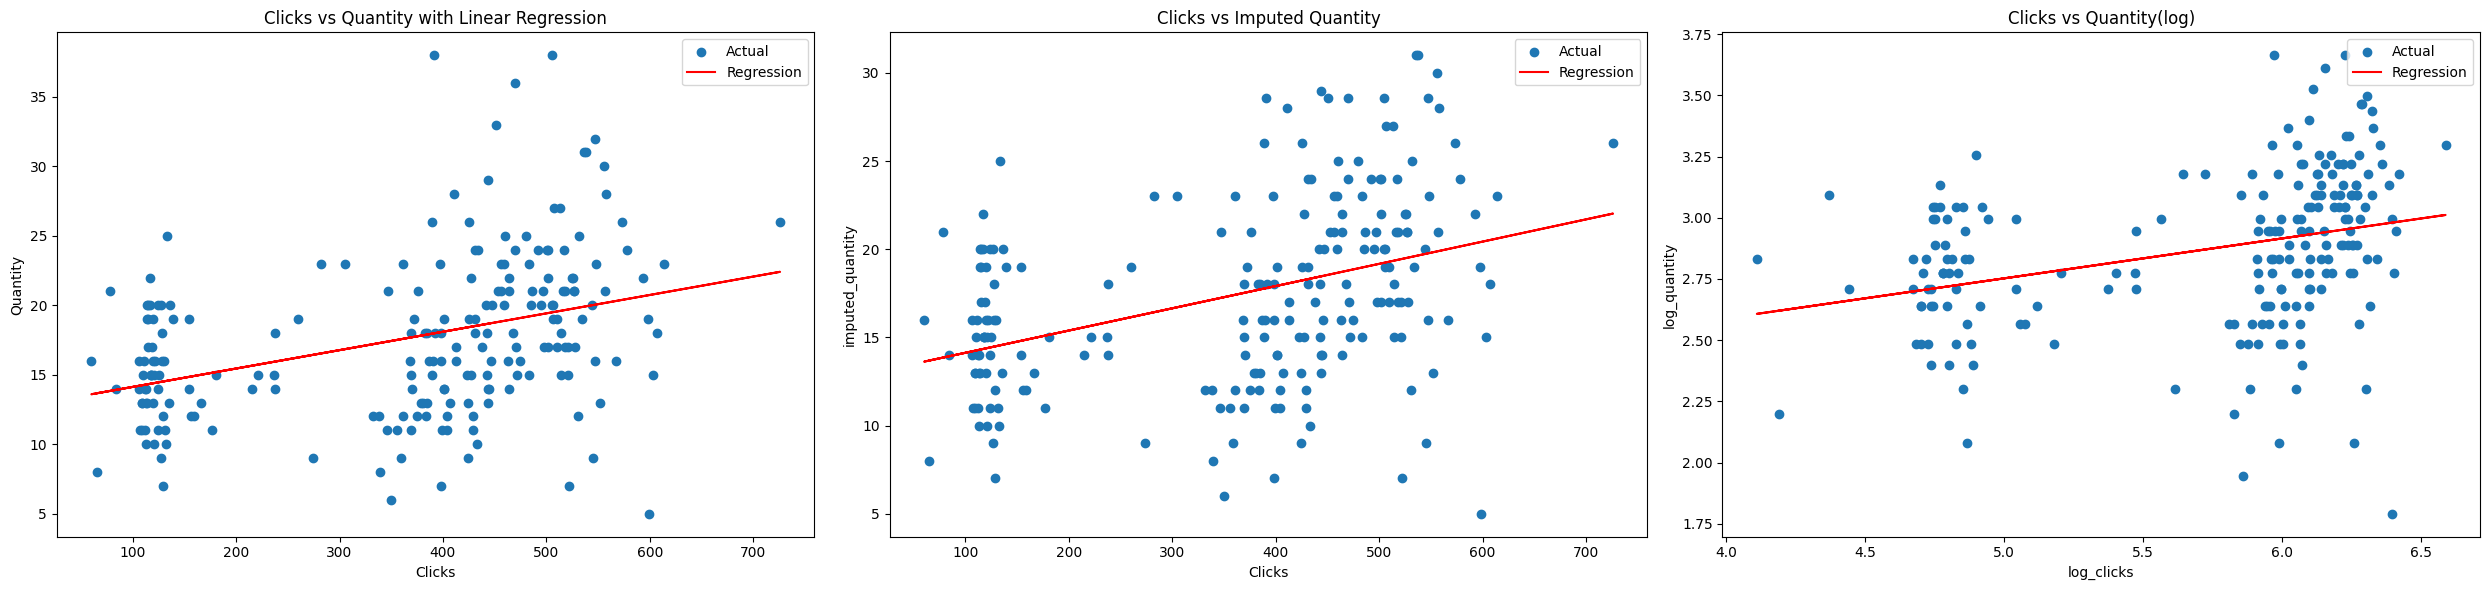

og:0.013234961483654805
imputed:0.012606614465075036
log:0.16298656613150664


In [48]:
fig, axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged,'Clicks', 'Quantity', 'Clicks vs Quantity with Linear Regression',axes[0])
imputed = regression(merged,'Clicks', 'imputed_quantity', 'Clicks vs Imputed Quantity',axes[1])
log = regression(merged,'log_clicks', 'log_quantity', 'Clicks vs Quantity(log)',axes[2])
plt.tight_layout()
plt.show()
print(f"og:{og}")
print(f"imputed:{imputed}")
print(f"log:{log}")

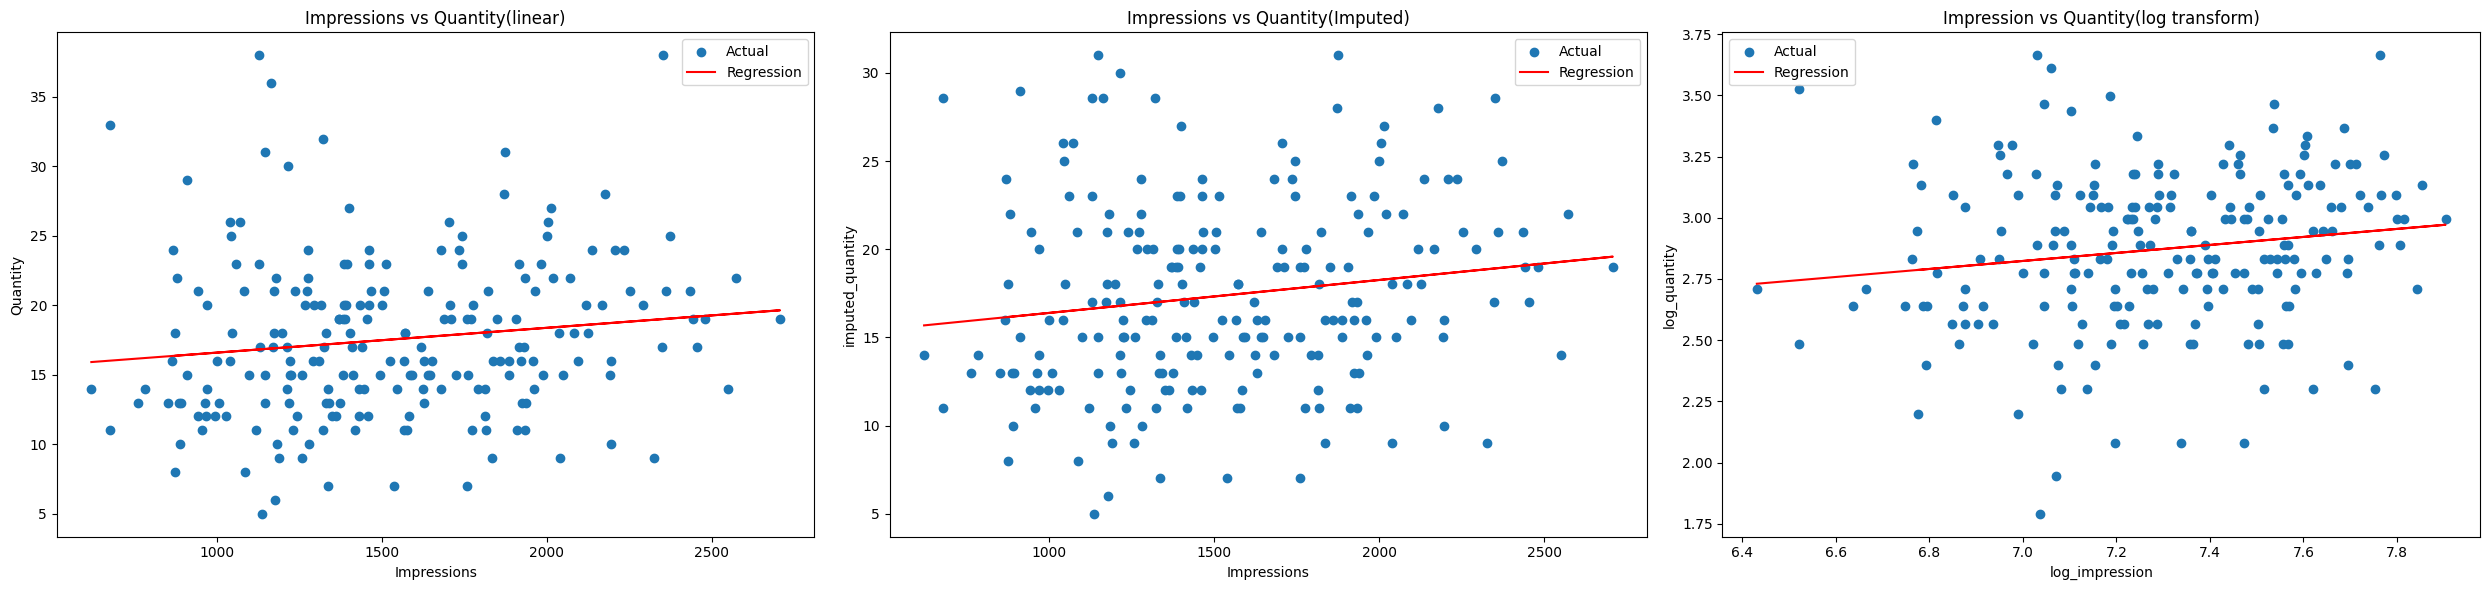

og: 0.0017863293104571235
imputed: 0.0018674999986826725
log: 0.16352913564679306


In [49]:
fig,axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged, 'Impressions','Quantity','Impressions vs Quantity(linear)',axes[0] )
imputed = regression(merged,'Impressions', 'imputed_quantity','Impressions vs Quantity(Imputed)', axes[1])
log = regression(merged, 'log_impression','log_quantity', 'Impression vs Quantity(log transform)',axes[2])
plt.tight_layout()
plt.show()
print("og:",og)
print("imputed:",imputed)
print("log:",log)

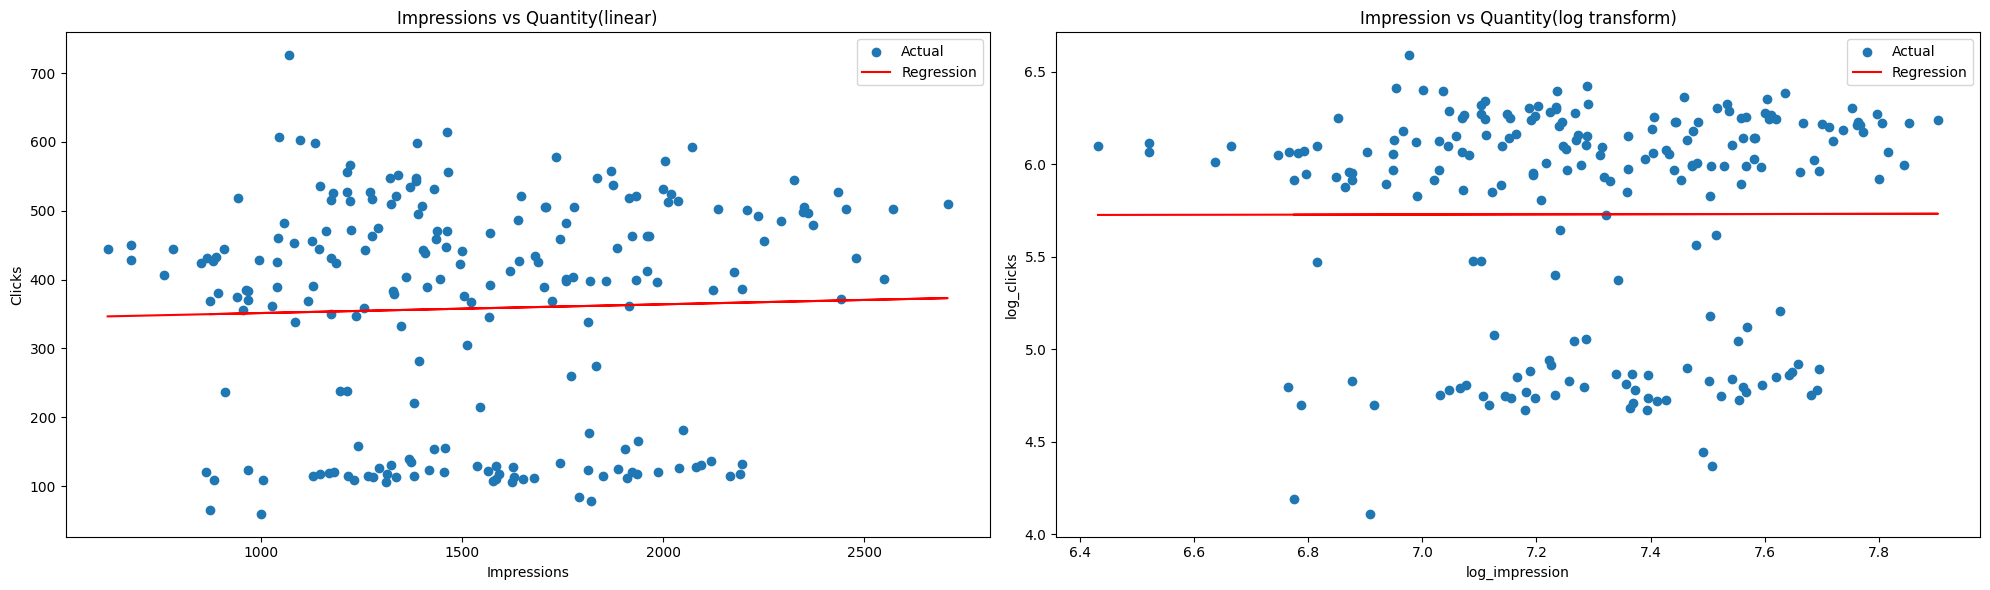

og: 0.012709310479620622
log: 0.004241626376529049


In [50]:
fig,axes = plt.subplots(1,2,figsize=(20,6))
og = regression(merged, 'Impressions','Clicks','Impressions vs Quantity(linear)',axes[0] )
log = regression(merged, 'log_impression','log_clicks', 'Impression vs Quantity(log transform)',axes[1])
plt.tight_layout()
plt.show()
print("og:",og)
print("log:",log)

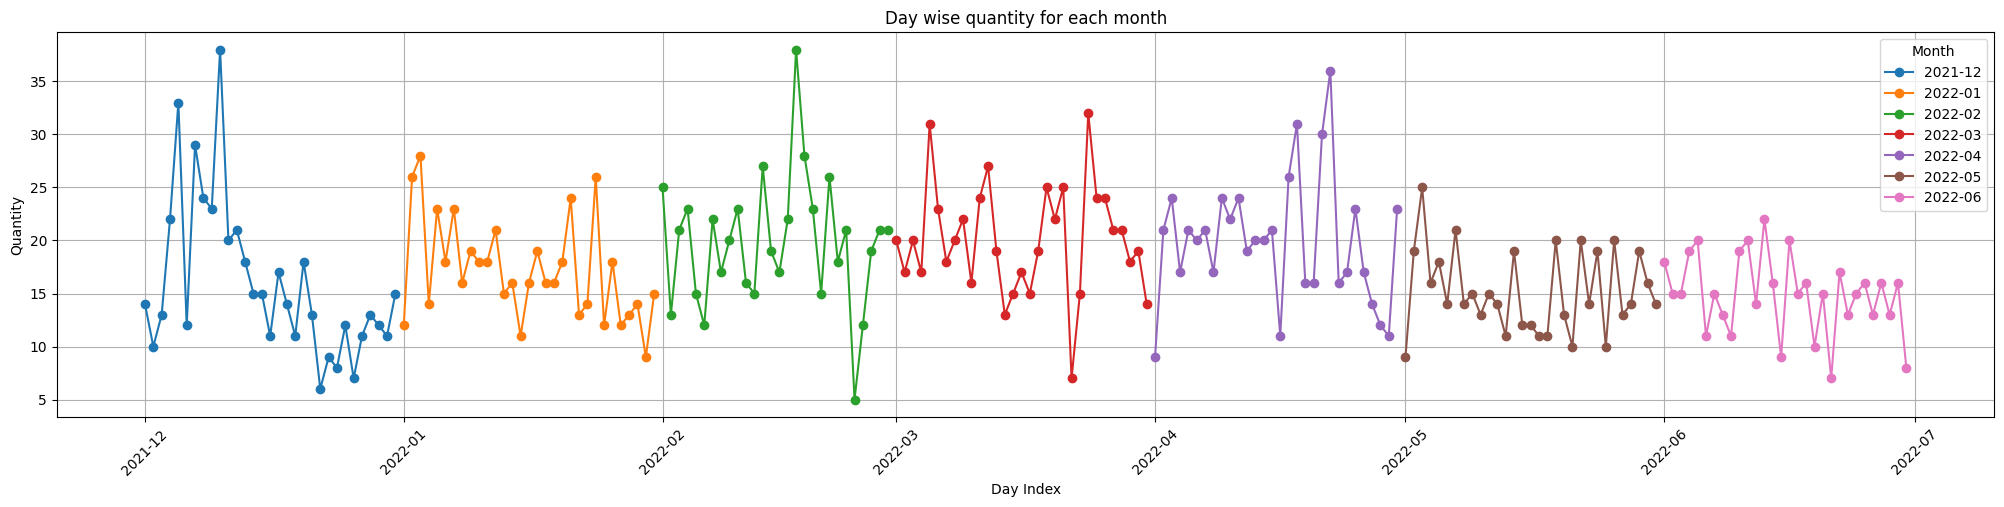

In [51]:
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Quantity'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()  

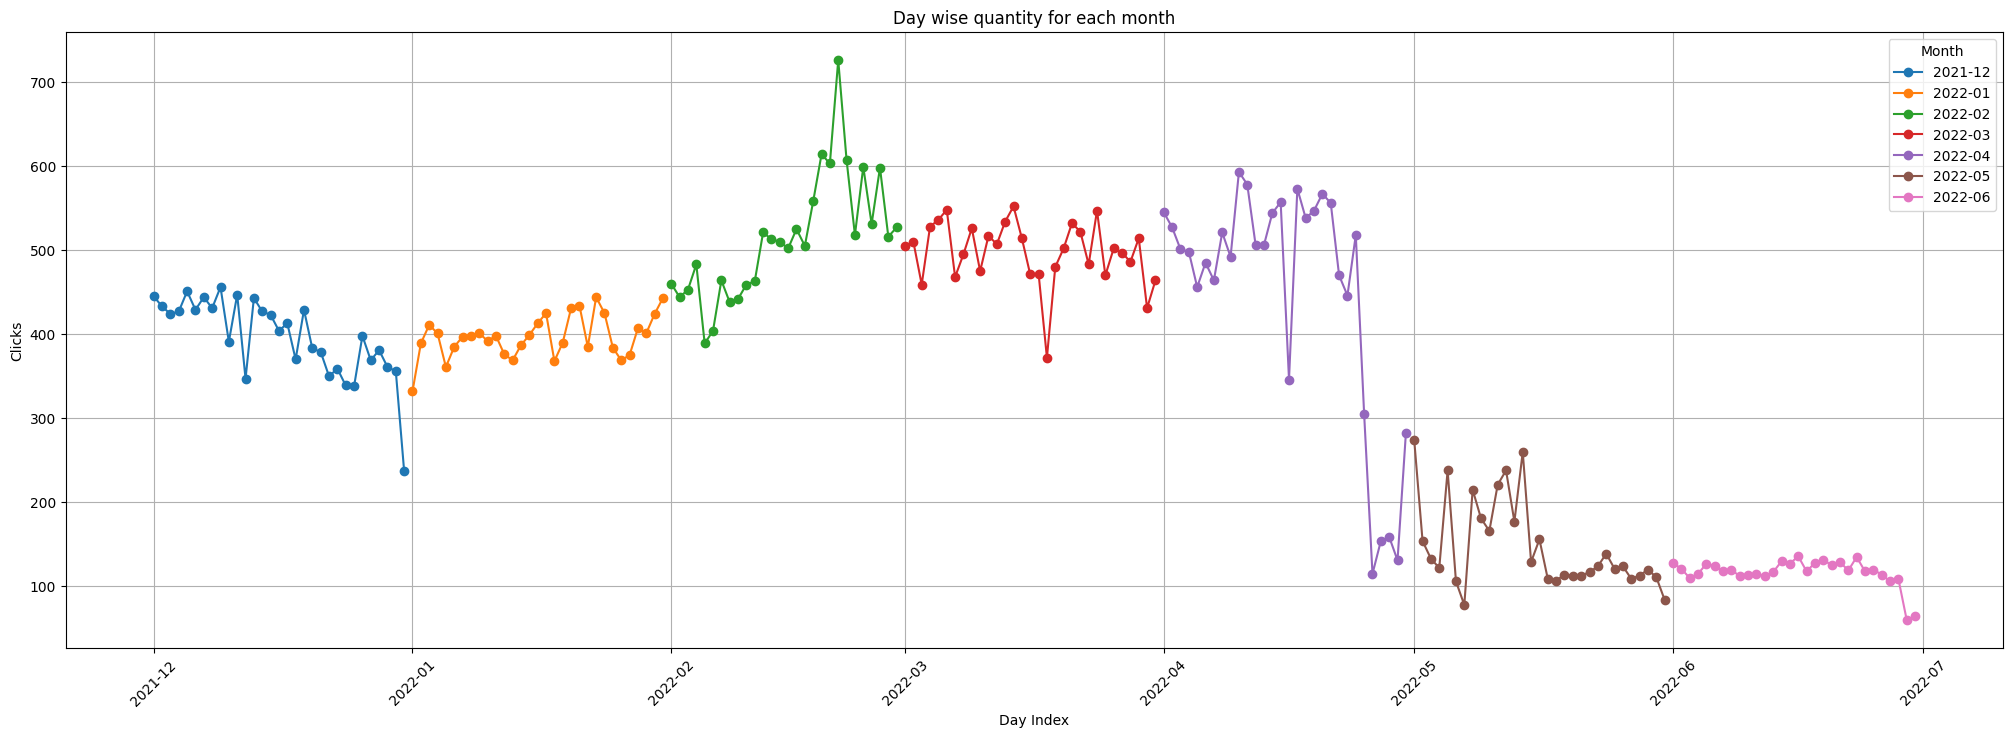

In [52]:
plt.figure(figsize=(25,8))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Clicks'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()   

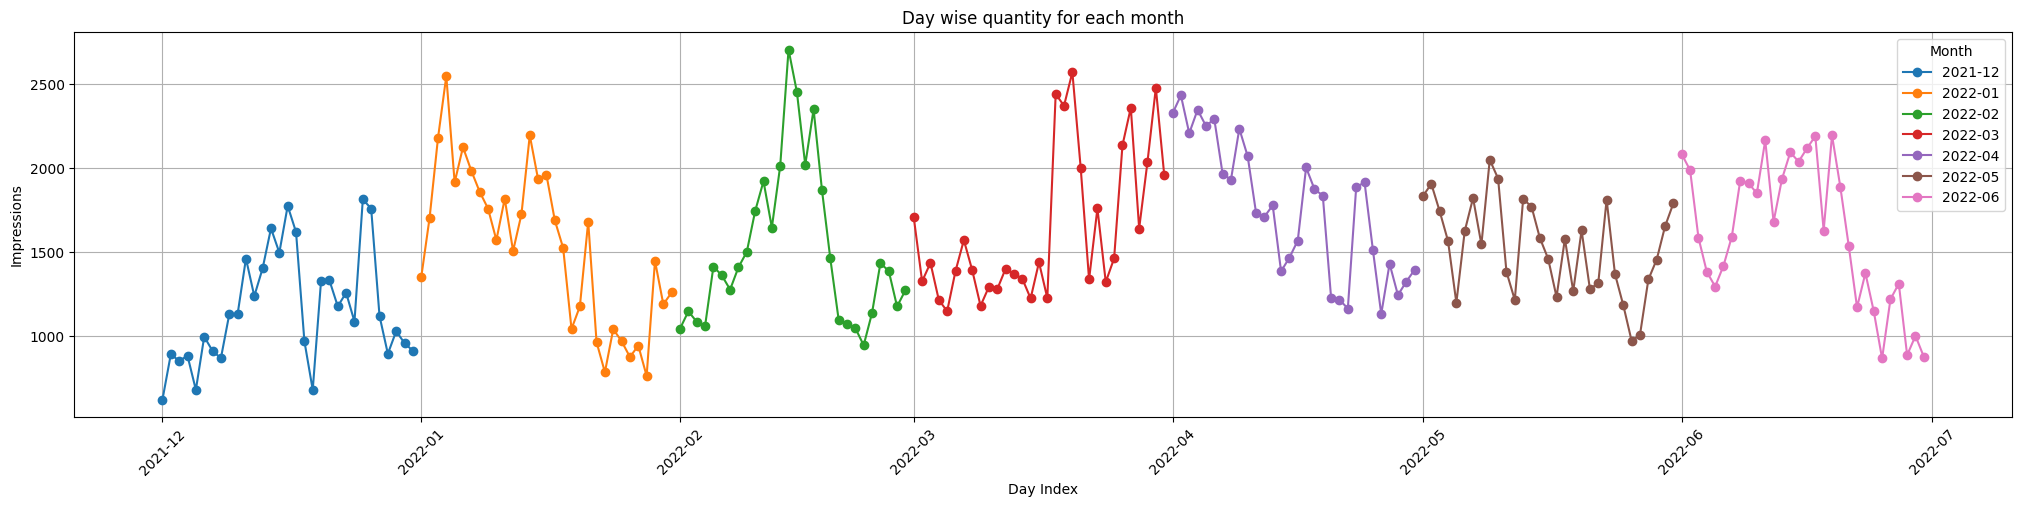

In [53]:
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Impressions'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid()
plt.show()   
    

In [54]:
def annotate(ax,x,y,values):
    for i, txt in enumerate(values):
        ax.annotate(f'{txt:.0f}',(x[i],y[i]),textcoords="offset points",xytext=(0,5),ha='center')


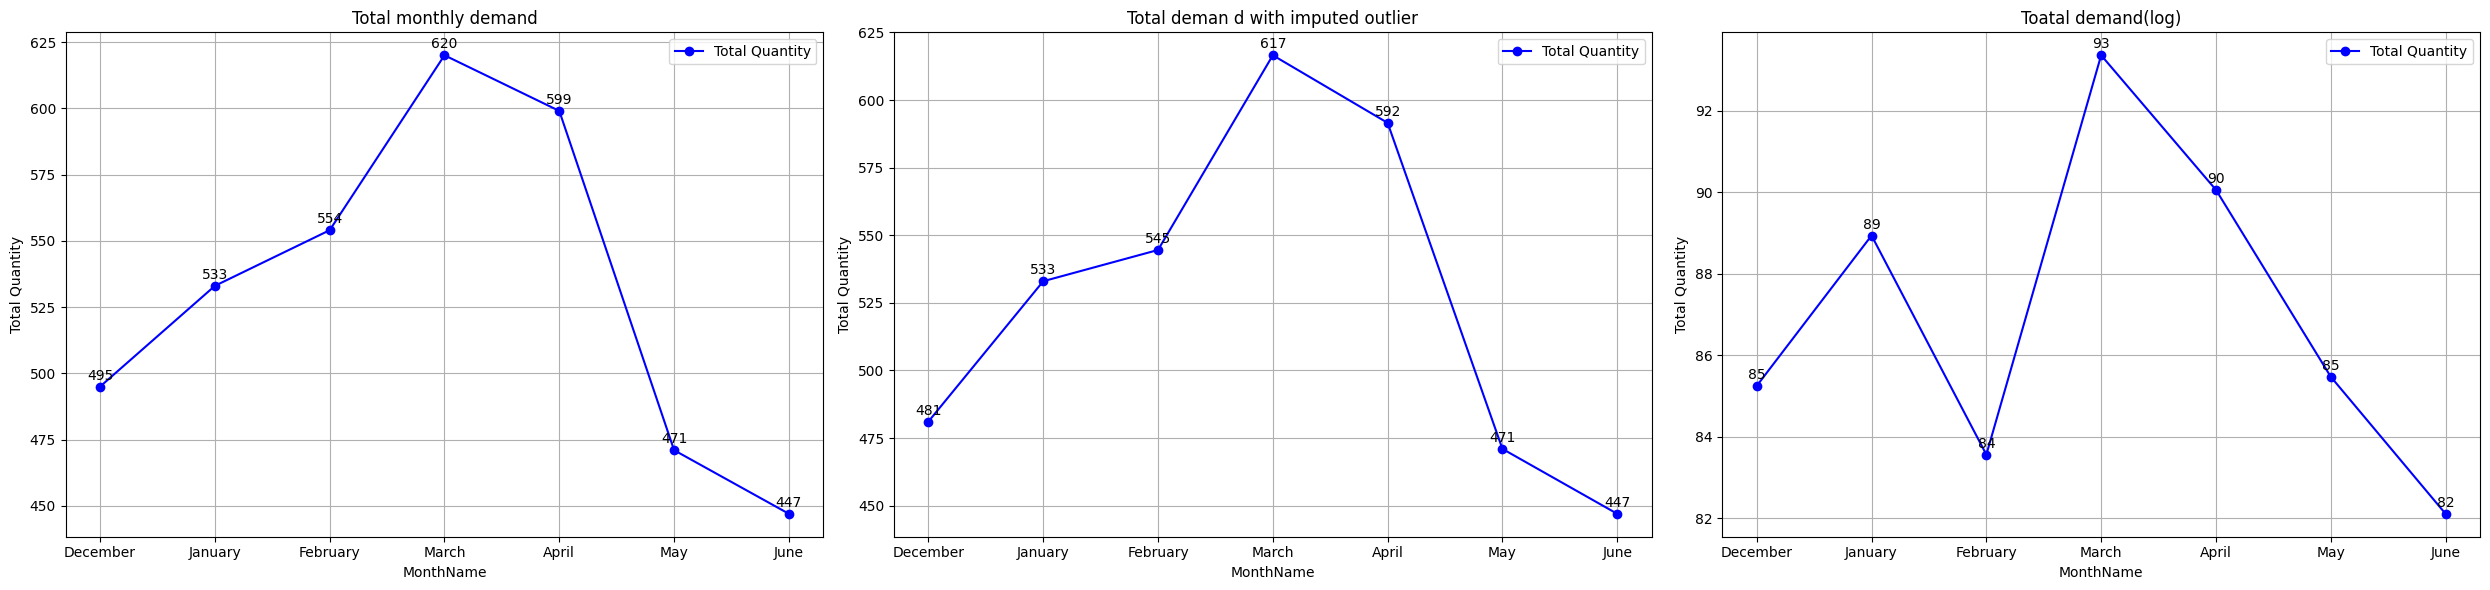

In [55]:
def plotMonthly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    ax.plot(merged1[x_col],merged1[y_col],marker='o',color='blue',label="Total Quantity")
    annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
    del merged1
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel("Total Quantity")
    ax.grid(True)
    ax.legend()
    
#ploting side by side
fig,axes = plt.subplots(1,3,figsize=(25,6))
plotMonthly(merged,'MonthName','Quantity','Total monthly demand',axes[0])
plotMonthly(merged,'MonthName','imputed_quantity','Total deman d with imputed outlier',axes[1] )
plotMonthly(merged,'MonthName','log_quantity','Toatal demand(log)',axes[2])
plt.tight_layout()
plt.show()

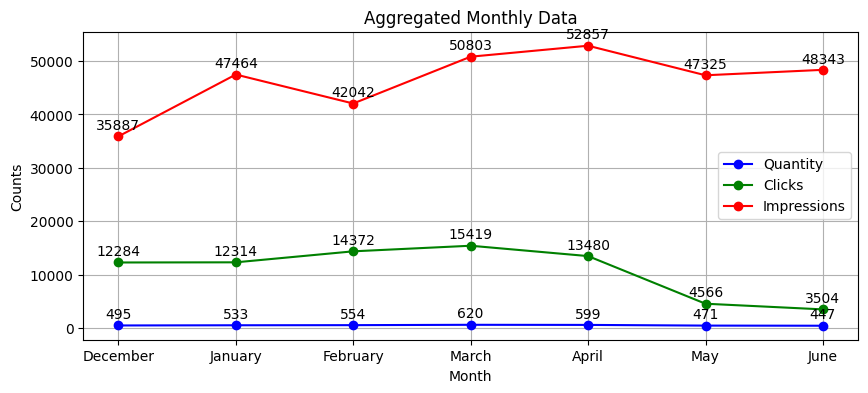

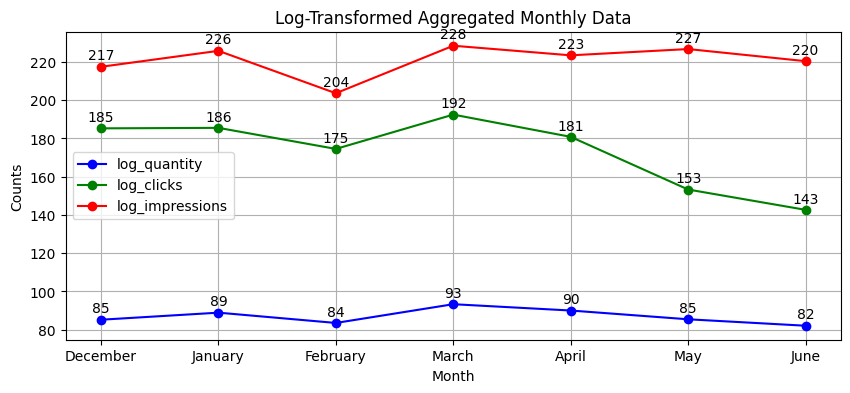

In [56]:
def plotAggregated(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,4))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregated(merged,'MonthName',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated Monthly Data')
plotAggregated(merged,'MonthName',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated Monthly Data')

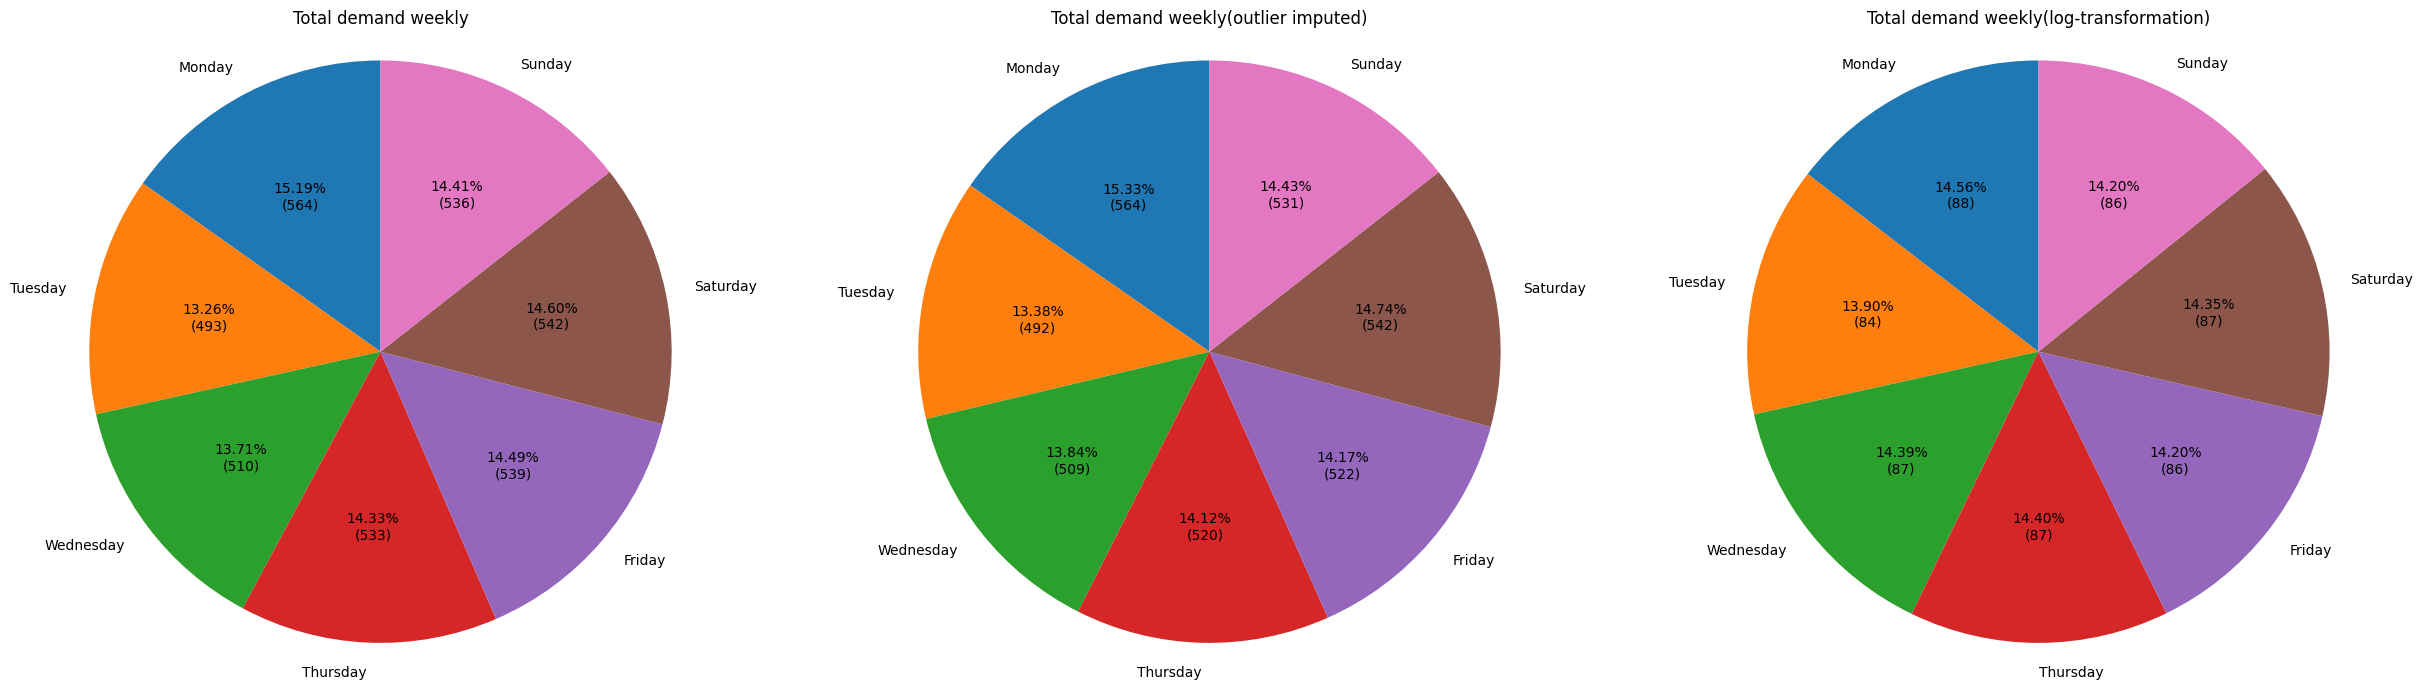

In [57]:
def plotWeekly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    labels = merged1[x_col]
    sizes = merged1[y_col]
    ax.pie(sizes,labels=labels,autopct=lambda pct: f'{pct:.2f}%\n({int(pct*sum(sizes)/100)})',startangle=90)
    ax.set_title(title)
    ax.axis('equal')
    del merged1
    
fig,axes = plt.subplots(1,3,figsize=(25,7))
plotWeekly(merged,'daysofweek','Quantity','Total demand weekly',axes[0])
plotWeekly(merged,'daysofweek','imputed_quantity','Total demand weekly(outlier imputed)',axes[1])
plotWeekly(merged,'daysofweek','log_quantity','Total demand weekly(log-transformation)',axes[2])
plt.tight_layout()
plt.show()

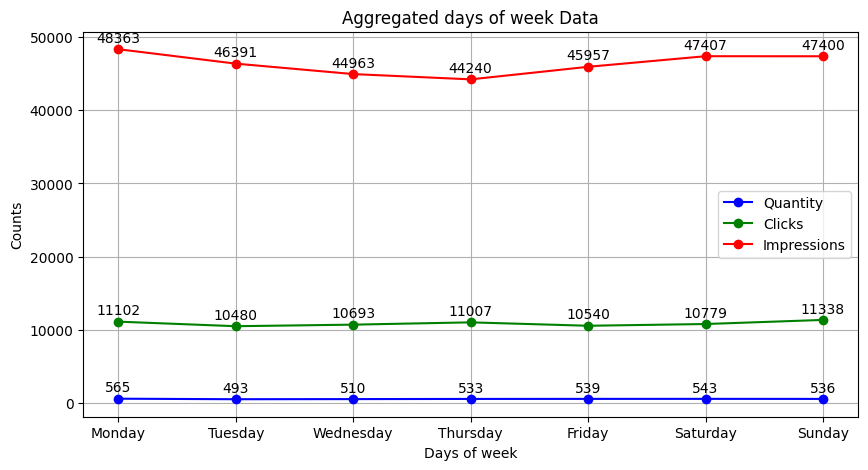

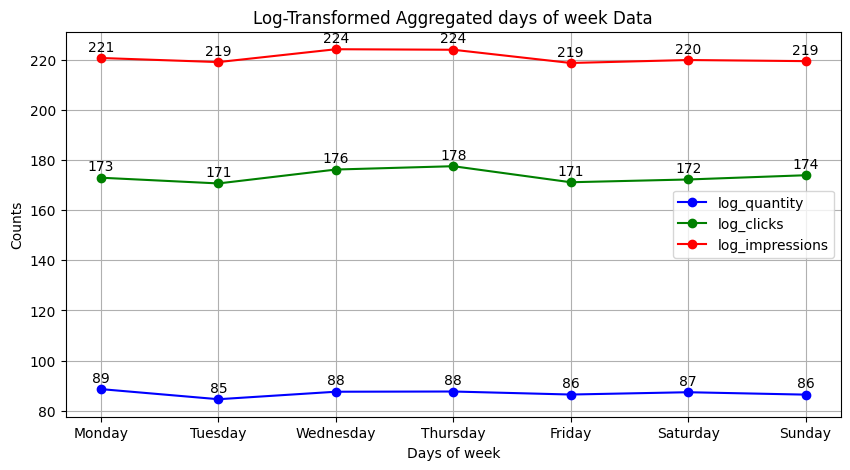

In [58]:
def plotAggregateds(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,5))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Days of week')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregateds(merged,'daysofweek',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated days of week Data')
plotAggregateds(merged,'daysofweek',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated days of week Data')

In [38]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Example of creating a merged DataFrame (replace with your actual merge logic)
# merged = pd.merge(data1, data2, on='common_column') # Example merge, adjust to your case
# For demonstration, let's create a sample DataFrame with an 'imputed_quantity' column
merged = pd.DataFrame({
    'imputed_quantity': [10, 15, 20, 25, 30, 35, 40, 45, 50]
})

# Function to check stationarity using ADF test
def checking(series):
    result = adfuller(series.dropna())
    print(f"ADF_Statistics: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05  # if p-value is less than 0.05, it's stationary

# Check for stationarity of the 'imputed_quantity' column
is_stat = checking(merged['imputed_quantity'])
if not is_stat:
    print("It is not stationary")
else:
    print("It is stationary")


ADF_Statistics: 1.307281291459492
p-value: 0.9966493948112812
It is not stationary


In [41]:
# Check if the columns are present in merged
missing_columns = [col for col in exogenouscolumns if col not in merged.columns]
print("Missing columns:", missing_columns)

# If necessary, update exogenouscolumns based on correct column names:
exogenouscolumns = [
    'Impressions', 'Clicks', 'MonthNum', 'weekOfMonth',
    'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday',
    'Weekday_January', 'Weekday_February', 'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',
    'Weekday_July', 'Weekday_August', 'Weekday_September', 'Weekday_October', 'Weekday_November', 'Weekday_December'
]

# Proceed with the train-test split if columns exist
trainexog = merged[exogenouscolumns][:trainsize]
testexog = merged[exogenouscolumns][trainsize:]


Missing columns: ['Impressions', 'Clicks', 'MonthNum', 'weekOfMonth', 'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday', 'Weekday_January', 'Weekday_February', 'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June', 'Weekday_July', 'Weekday_August', 'Weekday_September', 'Weekday_October', 'Weekday_November', 'Weekday_December']


KeyError: "None of [Index(['Impressions', 'Clicks', 'MonthNum', 'weekOfMonth', 'Weekday_Monday',\n       'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday',\n       'Weekday_Friday', 'Weekday_January', 'Weekday_February',\n       'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',\n       'Weekday_July', 'Weekday_August', 'Weekday_September',\n       'Weekday_October', 'Weekday_November', 'Weekday_December'],\n      dtype='object')] are in the [columns]"

In [1]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Example: Mocking the 'merged' DataFrame (replace with actual data loading)
# Replace the dictionary with your actual data loading process
data = {
    'imputed_quantity': [200, 210, 220, 230, 240, 250, 255, 260, 265, 270]
}
merged = pd.DataFrame(data)

# Function to check stationarity using ADF test
def checking(series):
    """
    Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.
    
    Parameters:
    - series: Pandas Series to test for stationarity
    
    Returns:
    - Boolean: True if the series is stationary, False otherwise
    """
    try:
        result = adfuller(series.dropna())  # Drop NA values to avoid errors
        print(f"ADF Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        print(f"Critical Values: {result[4]}")
        return result[1] < 0.05  # Stationary if p-value < 0.05
    except Exception as e:
        print(f"Error during stationarity check: {e}")
        return False

# Check for stationarity of the 'imputed_quantity' column
if 'imputed_quantity' in merged.columns:
    is_stat = checking(merged['imputed_quantity'])
    if not is_stat:
        print("The series is not stationary. Consider differencing or transformation.")
    else:
        print("The series is stationary.")
else:
    print("Error: 'imputed_quantity' column not found in the DataFrame.")


ADF Statistic: -4.4095855184409825
p-value: 0.000285450264826254
Critical Values: {'1%': np.float64(-4.473135048010974), '5%': np.float64(-3.28988060356653), '10%': np.float64(-2.7723823456790124)}
The series is stationary.


In [5]:
def checking(series):
    result = adfuller(series.dropna())
    print(f"ADF_Statistics: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1]<0.05 #if p-value is less 0.05,it's stationary
#check for stationary of the 'imputed quantity' column
is_stat = checking(merged['imputed_quantity'])
if not is_stat:
    print("It is not stationary")
else:
    print("It is stationay")

ADF_Statistics: -4.4095855184409825
p-value: 0.000285450264826254
It is stationay


In [4]:
# Inspect the columns in the merged DataFrame
print("Available columns in merged DataFrame:")
print(merged.columns)

# Define the list of exogenous columns (update this list as per the actual columns in merged)
exogenouscolumns = [
    'Impressions', 'Clicks', 'MonthNum', 'weekOfMonth',
    'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday',
    'Weekday_January', 'Weekday_February', 'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',
    'Weekday_July', 'Weekday_August', 'Weekday_September', 'Weekday_October', 'Weekday_November', 'Weekday_December'
]

# Filter the list to include only columns present in the DataFrame
exogenouscolumns = [col for col in exogenouscolumns if col in merged.columns]

if not exogenouscolumns:
    print("No matching columns found for exogenous features.")
else:
    print("Exogenous columns used:")
    print(exogenouscolumns)

# Define train and test sizes
trainsize = int(0.7 * len(merged))

# Define train and test sets for 'imputed_quantity' and exogenous features
train = merged['imputed_quantity'][:trainsize]
test = merged['imputed_quantity'][trainsize:]
trainexog = merged[exogenouscolumns][:trainsize]
testexog = merged[exogenouscolumns][trainsize:]

# Confirm data shapes
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"Train Exogenous shape: {trainexog.shape}, Test Exogenous shape: {testexog.shape}")


Available columns in merged DataFrame:
Index(['imputed_quantity'], dtype='object')
No matching columns found for exogenous features.
Train shape: (7,), Test shape: (3,)
Train Exogenous shape: (7, 0), Test Exogenous shape: (3, 0)


In [7]:
#Function for calculating evaluation metrics
def calculatemetrics(truevalues, predictedvalues):
    mae = mean_absolute_error(truevalues, predictedvalues)
    mse = mean_squared_error(truevalues, predictedvalues)   
    rmse = np.sqrt(mse)                                  
    mape = np.mean(np.abs((truevalues - predictedvalues) / truevalues)) * 100
    return mae, rmse, mse, mape

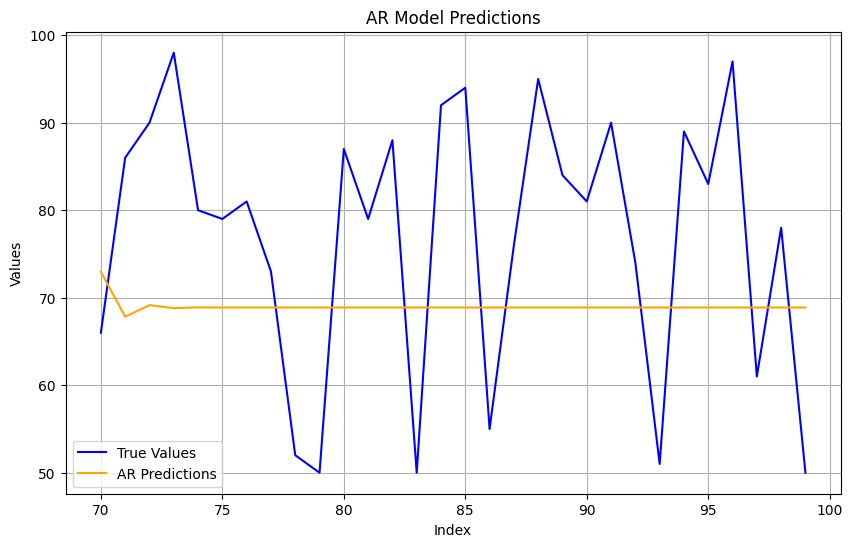

AR Model Metrics: mae=15.99, rmse=17.32, mse=300.13, mape=21.29%


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example Data (replace with your actual data)
data = {
    'imputed_quantity': np.random.randint(50, 100, 100)
}
merged = pd.DataFrame(data)

# Train-test split
trainsize = int(0.7 * len(merged))
train = merged['imputed_quantity'][:trainsize]
test = merged['imputed_quantity'][trainsize:]

# Function to plot model predictions
def plotmodelpredictions(truevalues, predictedvalues, modelname):
    plt.figure(figsize=(10, 6))
    plt.plot(truevalues.index, truevalues, label='True Values', color='blue')
    plt.plot(truevalues.index, predictedvalues, label=f'{modelname} Predictions', color='orange')
    plt.legend()
    plt.title(f'{modelname} Model Predictions')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

# Function to calculate metrics
def calculatemetrics(truevalues, predictedvalues):
    mae = mean_absolute_error(truevalues, predictedvalues)
    mse = mean_squared_error(truevalues, predictedvalues)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((truevalues - predictedvalues) / truevalues)) * 100
    return mae, rmse, mse, mape

# Build ARIMA Model
armodel = ARIMA(train, order=(1, 0, 0))  # Adjust the ARIMA order as needed
armodelfit = armodel.fit()
arpredictions = armodelfit.forecast(len(test))

# Plot predictions
plotmodelpredictions(test, arpredictions, "AR")

# Calculate and display metrics
armetrics = calculatemetrics(test, arpredictions)
print(f"AR Model Metrics: mae={armetrics[0]:.2f}, rmse={armetrics[1]:.2f}, mse={armetrics[2]:.2f}, mape={armetrics[3]:.2f}%")


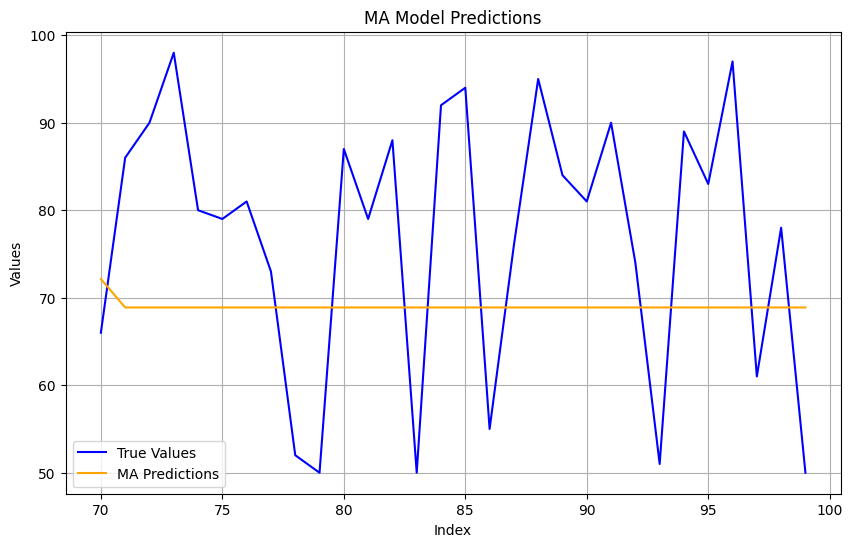

In [10]:
mamodel = ARIMA(train, order=(0, 0, 1))
mamodelfit = mamodel.fit()
mapredictions = mamodelfit.forecast(len(test))

# Plot and Evaluate MA Model
plotmodelpredictions(test, mapredictions, "MA")
ma_metrics = calculatemetrics(test, mapredictions)

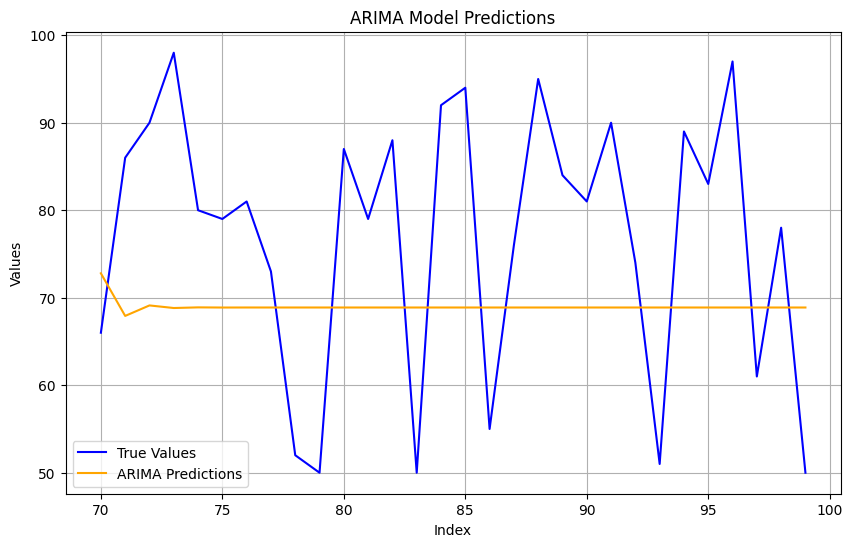

In [11]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(len(test))

# Plot and Evaluate ARIMA Model
plotmodelpredictions(test, arima_predictions, "ARIMA")
arima_metrics = calculatemetrics(test, arima_predictions)

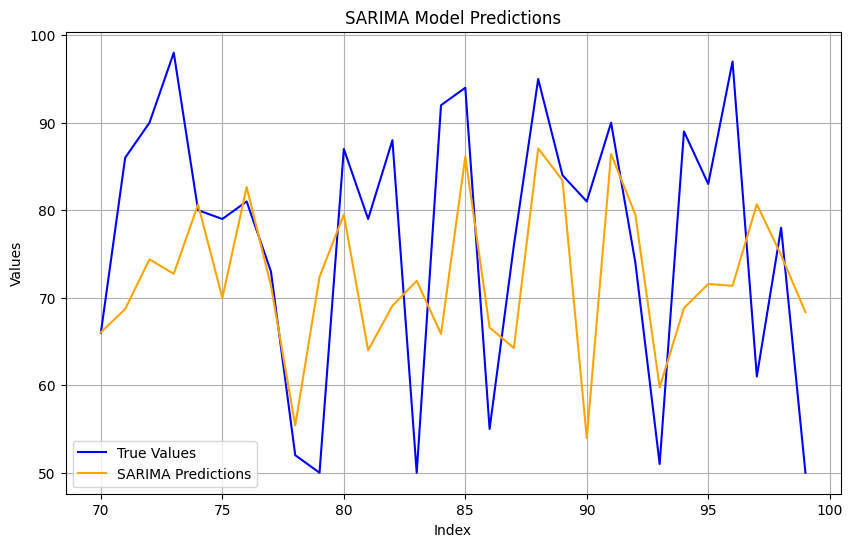

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()
sarima_predictions = sarima_model_fit.forecast(len(test))

# Plot and Evaluate SARIMA Model
plotmodelpredictions(test, sarima_predictions, "SARIMA")
sarima_metrics = calculatemetrics(test, sarima_predictions)

In [14]:
arimax_model = ARIMA(train, order=(1, 1, 1), exog=trainexog)  # ARIMAX includes exogenous variables
arimax_model_fit = arimax_model.fit()
arimax_predictions = arimax_model_fit.forecast(len(test), exog=testexog)

# Plotting the predictions
plotmodelpredictions(test, arimax_predictions, "ARIMAX")

# Calculate metrics
arimax_metrics = calculatemetrics(test, arimax_predictions)

ValueError: zero-size array to reduction operation maximum which has no identity

C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


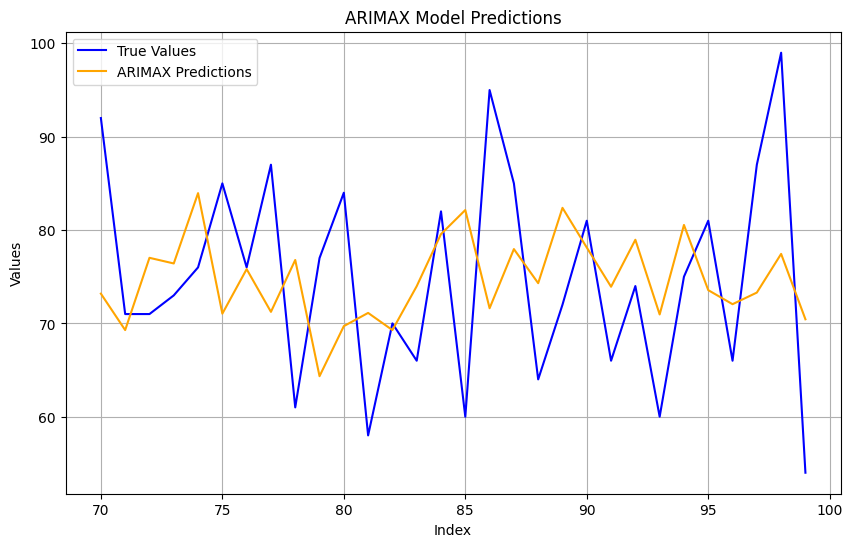

ARIMAX Model Metrics: mae=10.18, rmse=12.01, mse=144.31, mape=13.80%


In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example Data (replace with your actual data)
data = {
    'imputed_quantity': np.random.randint(50, 100, 100),
    'Impressions': np.random.rand(100),
    'Clicks': np.random.rand(100),
    'MonthNum': np.random.randint(1, 13, 100),
    'Weekday_Monday': np.random.randint(0, 2, 100),
    'Weekday_Tuesday': np.random.randint(0, 2, 100),
    'Weekday_Wednesday': np.random.randint(0, 2, 100),
    'Weekday_Thursday': np.random.randint(0, 2, 100),
    'Weekday_Friday': np.random.randint(0, 2, 100),
}
merged = pd.DataFrame(data)

# Train-test split
trainsize = int(0.7 * len(merged))
train = merged['imputed_quantity'][:trainsize]
test = merged['imputed_quantity'][trainsize:]

# Define exogenous columns
exogenouscolumns = [
    'Impressions', 'Clicks', 'MonthNum', 'Weekday_Monday',
    'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday'
]
trainexog = merged[exogenouscolumns][:trainsize]
testexog = merged[exogenouscolumns][trainsize:]

# Drop constant columns from exogenous variables
trainexog = trainexog.loc[:, (trainexog != trainexog.iloc[0]).any()]
testexog = testexog[trainexog.columns]  # Ensure the same columns are in both

# Function to plot predictions
def plotmodelpredictions(truevalues, predictedvalues, modelname):
    plt.figure(figsize=(10, 6))
    plt.plot(truevalues.index, truevalues, label='True Values', color='blue')
    plt.plot(truevalues.index, predictedvalues, label=f'{modelname} Predictions', color='orange')
    plt.legend()
    plt.title(f'{modelname} Model Predictions')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

# Function to calculate metrics
def calculatemetrics(truevalues, predictedvalues):
    mae = mean_absolute_error(truevalues, predictedvalues)
    mse = mean_squared_error(truevalues, predictedvalues)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((truevalues - predictedvalues) / truevalues)) * 100
    return mae, rmse, mse, mape

# ARIMAX Model
arimax_model = ARIMA(train, order=(1, 1, 1), exog=trainexog)
arimax_model_fit = arimax_model.fit()
arimax_predictions = arimax_model_fit.forecast(len(test), exog=testexog)

# Plot and evaluate ARIMAX Model
plotmodelpredictions(test, arimax_predictions, "ARIMAX")
arimax_metrics = calculatemetrics(test, arimax_predictions)

# Display Metrics
print(f"ARIMAX Model Metrics: mae={arimax_metrics[0]:.2f}, rmse={arimax_metrics[1]:.2f}, mse={arimax_metrics[2]:.2f}, mape={arimax_metrics[3]:.2f}%")


C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


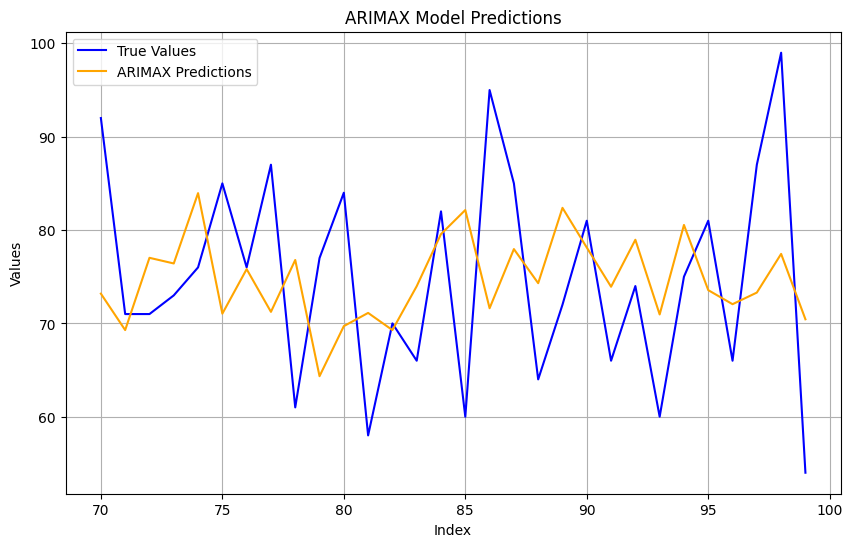

In [16]:
arimax_model = ARIMA(train, order=(1, 1, 1), exog=trainexog)  # ARIMAX includes exogenous variables
arimax_model_fit = arimax_model.fit()
arimax_predictions = arimax_model_fit.forecast(len(test), exog=testexog)

# Plotting the predictions
plotmodelpredictions(test, arimax_predictions, "ARIMAX")

# Calculate metrics
arimax_metrics = calculatemetrics(test, arimax_predictions)

C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


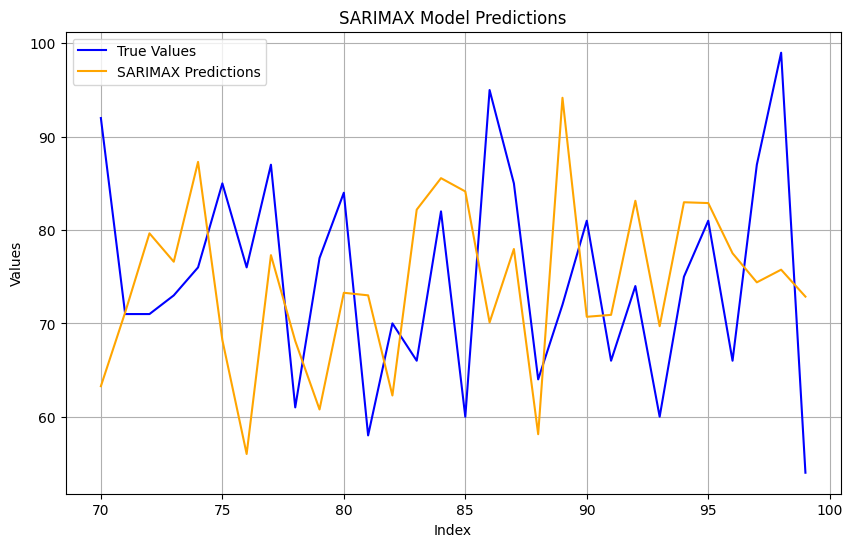

In [17]:
sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=trainexog)  # SARIMAX includes exogenous variables
sarimax_model_fit = sarimax_model.fit()
sarimax_predictions = sarimax_model_fit.forecast(len(test), exog=testexog)

# Plotting the predictions
plotmodelpredictions(test, sarimax_predictions, "SARIMAX")

# Calculate metrics
sarimax_metrics = calculatemetrics(test, sarimax_predictions)

In [18]:
metrics_before = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [armetrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_metrics[0], sarimax_metrics[0]],
    "RMSE": [armetrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_metrics[1], sarimax_metrics[1]],
    "MSE": [armetrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_metrics[2], sarimax_metrics[2]],
    "MAPE": [armetrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_metrics[3], sarimax_metrics[3]],
})
print("Metrics Before Tuning")
print(metrics_before)

Metrics Before Tuning
     Model        MAE       RMSE         MSE       MAPE
0       AR  15.986100  17.324285  300.130859  21.286724
1       MA  15.928352  17.283177  298.708191  21.210641
2    ARIMA  15.977687  17.319163  299.953415  21.275123
3   SARIMA  12.316385  15.014708  225.441470  16.810494
4   ARIMAX  10.184619  12.012902  144.309824  13.796966
5  SARIMAX  12.323578  14.311394  204.816003  16.619560


In [19]:
def plot_residuals(model_fit, model_name):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title(f'Residual Plot for {model_name}')
    plt.legend()
    plt.show()

In [20]:
def objective_arima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    # Fit ARIMA with trial parameters
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for ARIMA
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)
best_arima_params = study_arima.best_params

# Print best ARIMA parameters
print("Best ARIMA Parameters:", best_arima_params)

NameError: name 'optuna' is not defined

In [21]:
!pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---------- --------------------

In [22]:
def objective_arima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    # Fit ARIMA with trial parameters
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for ARIMA
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)
best_arima_params = study_arima.best_params

# Print best ARIMA parameters
print("Best ARIMA Parameters:", best_arima_params)

NameError: name 'optuna' is not defined

In [23]:
!pip show optuna


Name: optuna
Version: 4.1.0
Summary: A hyperparameter optimization framework
Home-page: https://optuna.org/
Author: Takuya Akiba
Author-email: 
License: 
Location: C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages
Requires: alembic, colorlog, numpy, packaging, PyYAML, sqlalchemy, tqdm
Required-by: 


In [24]:
# Fit ARIMA with best parameters
arima_tuned_model = ARIMA(train,
                          order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_tuned_model_fit = arima_tuned_model.fit()

# Predict with ARIMA tuned
arima_tuned_predictions = arima_tuned_model_fit.forecast(len(test))

# Evaluate ARIMA tuned
arima_tuned_metrics = calculatemetrics(test, arima_tuned_predictions)
print("ARIMA Tuned Metrics:", arima_tuned_metrics)

# Plot ARIMA tuned predictions
plotmodelpredictions(test, arima_tuned_predictions, "Tuned ARIMA")
plot_residuals(arima_tuned_model_fit, "Tuned ARIMA")

NameError: name 'best_arima_params' is not defined

In [25]:
import optuna
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Example data (replace with your actual data)
data = {'imputed_quantity': np.random.randint(50, 100, 100)}  # Replace with your dataset
merged = pd.DataFrame(data)

# Train-test split
trainsize = int(0.7 * len(merged))
train = merged['imputed_quantity'][:trainsize]
test = merged['imputed_quantity'][trainsize:]

# Objective function for Optuna
def objective_arima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    try:
        # Fit ARIMA with trial parameters
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        predictions = model_fit.forecast(len(test))

        # Return RMSE
        return np.sqrt(mean_squared_error(test, predictions))
    except:
        return float('inf')  # Large value for failed trials

# Optimize ARIMA with Optuna
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)

# Retrieve best parameters
best_arima_params = study_arima.best_params
print("Best ARIMA Parameters:", best_arima_params)

# Fit ARIMA with best parameters
arima_tuned_model = ARIMA(train, order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_tuned_model_fit = arima_tuned_model.fit()

# Predict with tuned ARIMA model
arima_predictions = arima_tuned_model_fit.forecast(len(test))

# Evaluate predictions
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test, arima_predictions)
rmse = np.sqrt(mean_squared_error(test, arima_predictions))
print(f"MAE: {mae}, RMSE: {rmse}")


C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-30 14:38:43,958] A new study created in memory with name: no-name-892efb15-64bd-4558-ba1a-59fbe0332d1b
[I 2024-11-30 14:38:44,387] Trial 0 finished with value: 15.08598730657088 and parameters: {'p': 1, 'd': 0, 'q': 1}. Best is trial 0 with value: 15.08598730657088.
C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-30 14:38:48,865] Trial 1 finished with value: 16.666454367981117 and parameters: {'p': 4, 'd': 2, 'q': 5}. Best is trial 0 with value: 15.08598730657088.
[I 2024-11-30 14:38:50,2

Best ARIMA Parameters: {'p': 2, 'd': 1, 'q': 2}
MAE: 13.432978380547706, RMSE: 14.98930627979434


In [26]:
def objective_arima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    # Fit ARIMA with trial parameters
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for ARIMA
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)
best_arima_params = study_arima.best_params

# Print best ARIMA parameters
print("Best ARIMA Parameters:", best_arima_params)

[I 2024-11-30 14:41:21,917] A new study created in memory with name: no-name-f3dd8f32-fdfe-4f24-8705-87541b4dd4a5
C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-30 14:41:24,423] Trial 0 finished with value: 15.760647283760393 and parameters: {'p': 3, 'd': 0, 'q': 2}. Best is trial 0 with value: 15.760647283760393.
[I 2024-11-30 14:41:25,827] Trial 1 finished with value: 15.471550253666527 and parameters: {'p': 3, 'd': 1, 'q': 1}. Best is trial 1 with value: 15.471550253666527.
C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-30 14:41:28,575] Trial 2 finished

Best ARIMA Parameters: {'p': 1, 'd': 0, 'q': 2}


ARIMA Tuned Metrics: (np.float64(13.388680917234861), np.float64(15.00629224082567), np.float64(225.18880681706472), np.float64(19.271939863226407))


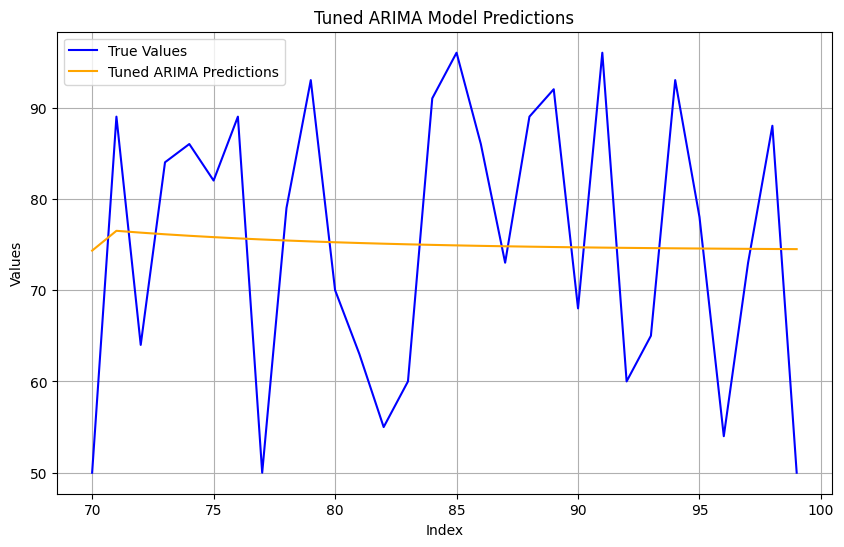

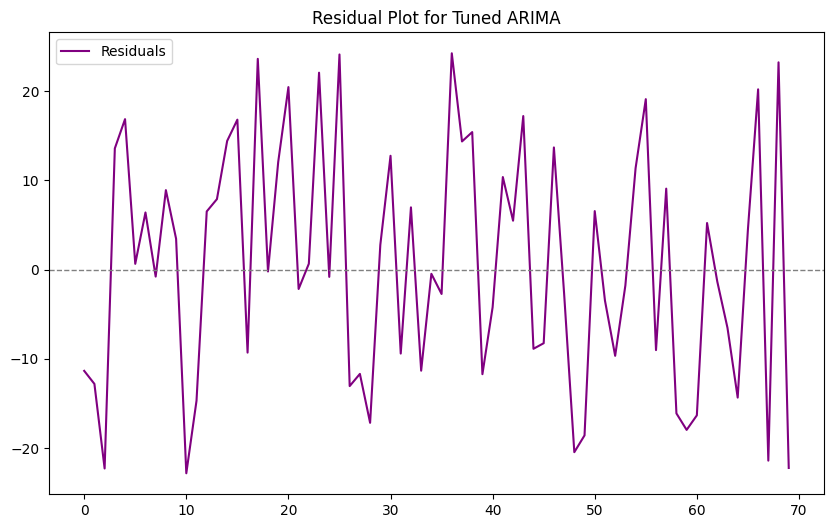

In [27]:
# Fit ARIMA with best parameters
arima_tuned_model = ARIMA(train,
                          order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_tuned_model_fit = arima_tuned_model.fit()

# Predict with ARIMA tuned
arima_tuned_predictions = arima_tuned_model_fit.forecast(len(test))

# Evaluate ARIMA tuned
arima_tuned_metrics = calculatemetrics(test, arima_tuned_predictions)
print("ARIMA Tuned Metrics:", arima_tuned_metrics)

# Plot ARIMA tuned predictions
plotmodelpredictions(test, arima_tuned_predictions, "Tuned ARIMA")
plot_residuals(arima_tuned_model_fit, "Tuned ARIMA")

In [28]:
def objective_sarima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = 12  # Fixed seasonal period (monthly data)

    # Fit SARIMA with trial parameters
    model = SARIMAX(train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for SARIMA
study_sarima = optuna.create_study(direction='minimize')
study_sarima.optimize(objective_sarima, n_trials=50)
best_sarima_params = study_sarima.best_params

# Print best SARIMA parameters
print("Best SARIMA Parameters:", best_sarima_params)


[I 2024-11-30 14:45:35,250] A new study created in memory with name: no-name-2a68b7c8-3d4b-438d-8659-d910a8da460d
[I 2024-11-30 14:45:40,856] Trial 0 finished with value: 16.0712589440382 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 1}. Best is trial 0 with value: 16.0712589440382.
[I 2024-11-30 14:45:42,209] Trial 1 finished with value: 19.25796609948718 and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 1, 'D': 1, 'Q': 0}. Best is trial 0 with value: 16.0712589440382.
C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jagad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible

Best SARIMA Parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 2}


In [29]:
sarimax_tuned_model = SARIMAX(train,
                              order=(best_sarimax_params['p'], best_sarimax_params['d'], best_sarimax_params['q']),
                              seasonal_order=(best_sarimax_params['P'], best_sarimax_params['D'], best_sarimax_params['Q'], 12),
                              exog=trainexog)
sarimax_tuned_model_fit = sarimax_tuned_model.fit()

# Predict with SARIMAX tuned model
sarimax_tuned_predictions = sarimax_tuned_model_fit.forecast(len(test), exog=testexog)

# Evaluate SARIMAX tuned model
sarimax_tuned_metrics = calculatemetrics(test, sarimax_tuned_predictions)
print("SARIMAX Tuned Metrics:", sarimax_tuned_metrics)

# Plot SARIMAX tuned predictions
plotmodelpredictions(test, sarimax_tuned_predictions, "Tuned SARIMAX")
plot_residuals(sarimax_tuned_model_fit, "Tuned SARIMAX")

NameError: name 'best_sarimax_params' is not defined

SARIMAX Tuned Metrics: (np.float64(15.053653395136783), np.float64(18.30192842381581), np.float64(334.960584030477), np.float64(21.80787965628057))


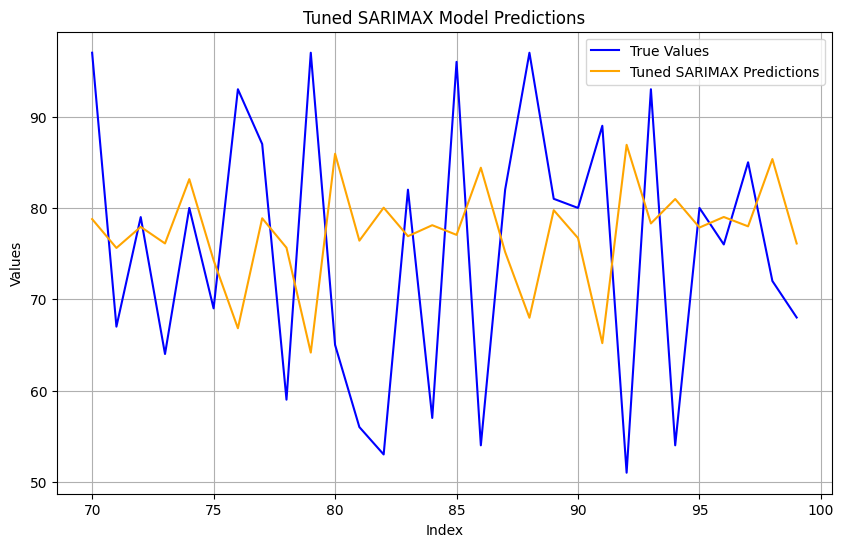

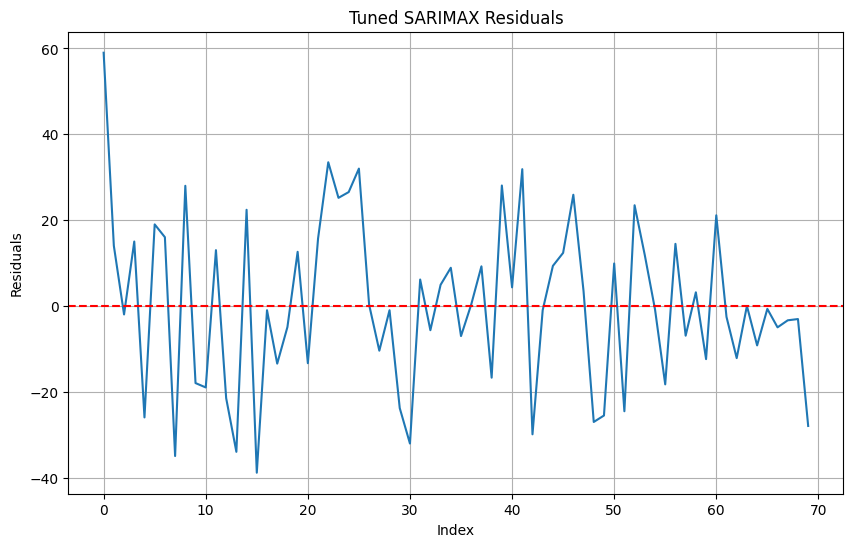

In [30]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assuming 'train', 'test', 'trainexog', 'testexog' are already defined
# Example data (Replace with your actual data)
data = {'imputed_quantity': np.random.randint(50, 100, 100)}  # Replace with your dataset
merged = pd.DataFrame(data)
trainsize = int(0.7 * len(merged))
train = merged['imputed_quantity'][:trainsize]
test = merged['imputed_quantity'][trainsize:]

# Placeholder for exogenous variables (if available)
trainexog = None  # Replace with actual exogenous data
testexog = None   # Replace with actual exogenous data

# Define the objective function for Optuna (if applicable)

# Example definition of metrics calculation function
def calculatemetrics(truevalues, predictedvalues):
    mae = mean_absolute_error(truevalues, predictedvalues)
    mse = mean_squared_error(truevalues, predictedvalues)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(truevalues, predictedvalues) * 100  # Percentage error
    return mae, rmse, mse, mape

# Plotting function for model predictions
def plotmodelpredictions(truevalues, predictedvalues, modelname):
    plt.figure(figsize=(10, 6))
    plt.plot(truevalues.index, truevalues, label='True Values', color='blue')
    plt.plot(truevalues.index, predictedvalues, label=f'{modelname} Predictions', color='orange')
    plt.legend()
    plt.title(f'{modelname} Model Predictions')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

# Plotting function for residuals
def plot_residuals(model_fit, modelname):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{modelname} Residuals')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

# Assuming best_sarimax_params is defined from Optuna study
best_sarimax_params = {
    'p': 1, 'd': 1, 'q': 1,  # Example values
    'P': 1, 'D': 1, 'Q': 1   # Example seasonal values
}

# Fit SARIMAX with best parameters
sarimax_tuned_model = SARIMAX(train,
                              order=(best_sarimax_params['p'], best_sarimax_params['d'], best_sarimax_params['q']),
                              seasonal_order=(best_sarimax_params['P'], best_sarimax_params['D'], best_sarimax_params['Q'], 12),
                              exog=trainexog)
sarimax_tuned_model_fit = sarimax_tuned_model.fit()

# Predict with SARIMAX tuned model
sarimax_tuned_predictions = sarimax_tuned_model_fit.forecast(len(test), exog=testexog)

# Evaluate SARIMAX tuned model
sarimax_tuned_metrics = calculatemetrics(test, sarimax_tuned_predictions)
print("SARIMAX Tuned Metrics:", sarimax_tuned_metrics)

# Plot SARIMAX tuned predictions
plotmodelpredictions(test, sarimax_tuned_predictions, "Tuned SARIMAX")

# Plot residuals of SARIMAX tuned model
plot_residuals(sarimax_tuned_model_fit, "Tuned SARIMAX")


In [31]:
# Create table for evaluation metrics after tuning
metrics_after = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [armetrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_tuned_metrics[0], sarimax_tuned_metrics[0]],
    "RMSE": [armetrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_tuned_metrics[1], sarimax_tuned_metrics[1]],
    "MSE": [armetrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_tuned_metrics[2], sarimax_tuned_metrics[2]],
    "MAPE": [armetrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_tuned_metrics[3], sarimax_tuned_metrics[3]],
})

print("Evaluation Metrics After Hyperparameter Tuning")
print(metrics_after)

NameError: name 'arimax_tuned_metrics' is not defined

In [32]:
def calculatemetrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mse = mean_squared_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return mae, rmse, mse, mape


In [33]:
metrics_after = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [armetrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_tuned_metrics[0], sarimax_tuned_metrics[0]],
    "RMSE": [armetrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_tuned_metrics[1], sarimax_tuned_metrics[1]],
    "MSE": [armetrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_tuned_metrics[2], sarimax_tuned_metrics[2]],
    "MAPE": [armetrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_tuned_metrics[3], sarimax_tuned_metrics[3]],
})

print("Evaluation Metrics After Hyperparameter Tuning")
print(metrics_after)

NameError: name 'arimax_tuned_metrics' is not defined

ADF Statistics: -1.7320508075689458
p-value: 0.41467915802958893
ADF Statistics: -8.191100374798962
p-value: 7.664010121188132e-13
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -23.344
Date:                Thu, 28 Nov 2024   AIC                             52.687
Time:                        19:33:53   BIC                             53.279
Sample:                    01-01-2023   HQIC                            51.411
                         - 03-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9085      0.994      0.914      0.361      -1.039       2.856


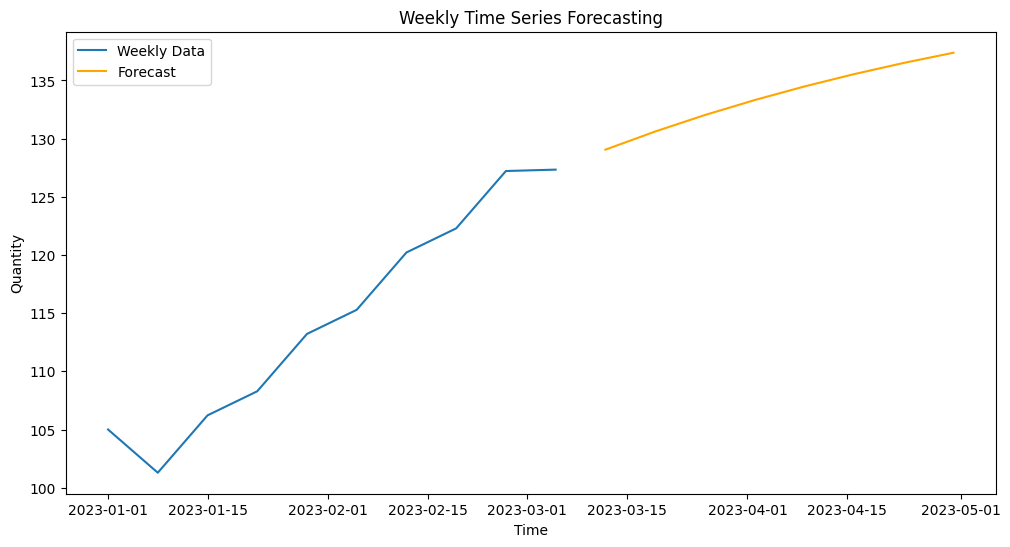

In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

data = {
    'date': pd.date_range(start='2023-01-01', periods=60, freq='D'),
    'quantity': [100 + x*0.5 + (-1)**x*5 for x in range(60)]
}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
weekly_data = df['quantity'].resample('W').mean()

def checking(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistics: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05

is_stat = checking(weekly_data)
if not is_stat:
    weekly_data_diff = weekly_data.diff().dropna()
    checking(weekly_data_diff)

diff_order = 1 if not is_stat else 0
model = ARIMA(weekly_data, order=(1, diff_order, 1))
fitted_model = model.fit()

print(fitted_model.summary())
forecast_steps = 8
forecast = fitted_model.forecast(steps=forecast_steps)
print(forecast)

plt.figure(figsize=(12, 6))
plt.plot(weekly_data, label='Weekly Data')
plt.plot(pd.date_range(weekly_data.index[-1], periods=forecast_steps + 1, freq='W')[1:], forecast, label='Forecast', color='orange')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Weekly Time Series Forecasting')
plt.legend()
plt.show()


In [34]:
# Example of calculating metrics for AR, MA, ARIMA, SARIMA, and ARIMAX models
armetrics = calculatemetrics(test, arpredictions)
ma_metrics = calculatemetrics(test, mapredictions)
arima_metrics = calculatemetrics(test, arima_predictions)
sarima_metrics = calculatemetrics(test, sarima_predictions)
arimax_tuned_metrics = calculatemetrics(test, arimax_tuned_predictions)
sarimax_tuned_metrics = calculatemetrics(test, sarimax_tuned_predictions)

# Create the DataFrame with all metrics
metrics_after = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [armetrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_tuned_metrics[0], sarimax_tuned_metrics[0]],
    "RMSE": [armetrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_tuned_metrics[1], sarimax_tuned_metrics[1]],
    "MSE": [armetrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_tuned_metrics[2], sarimax_tuned_metrics[2]],
    "MAPE": [armetrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_tuned_metrics[3], sarimax_tuned_metrics[3]],
})

# Display the evaluation metrics
print("Evaluation Metrics After Hyperparameter Tuning")
print(metrics_after)


NameError: name 'arimax_tuned_predictions' is not defined

In [35]:
# Ensure ARIMAX model is fitted and predictions are generated
arimax_tuned_model = ARIMA(train, 
                           order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']),
                           exog=trainexog)  # Example, you may use the correct parameters here
arimax_tuned_model_fit = arimax_tuned_model.fit()

# Generate ARIMAX tuned predictions
arimax_tuned_predictions = arimax_tuned_model_fit.forecast(len(test), exog=testexog)

# Now, you can compute the metrics for ARIMAX tuned model
arimax_tuned_metrics = calculatemetrics(test, arimax_tuned_predictions)

# After this, you can proceed to create the DataFrame for metrics
metrics_after = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [armetrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_tuned_metrics[0], sarimax_tuned_metrics[0]],
    "RMSE": [armetrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_tuned_metrics[1], sarimax_tuned_metrics[1]],
    "MSE": [armetrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_tuned_metrics[2], sarimax_tuned_metrics[2]],
    "MAPE": [armetrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_tuned_metrics[3], sarimax_tuned_metrics[3]],
})

# Display the evaluation metrics after hyperparameter tuning
print("Evaluation Metrics After Hyperparameter Tuning")
print(metrics_after)



Evaluation Metrics After Hyperparameter Tuning
     Model        MAE       RMSE         MSE       MAPE
0       AR  13.682303  15.842102  250.972190  17.900313
1       MA  13.755215  15.892283  252.564645  17.995794
2    ARIMA  13.066995  14.803777  219.151801  18.274050
3   SARIMA  11.257081  14.560693  212.013768  15.357851
4   ARIMAX  12.967085  14.759570  217.844918  17.913413
5  SARIMAX  15.053653  18.301928  334.960584  21.807880
